In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import pickle
import dill

from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn import set_config
import xgboost as xgb
set_config(display='diagram')

import eli5
import config

pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 99)
pd.set_option('display.max_colwidth', None)

### NYC Parking Violations and Results

#### Load Data from Postgres and Pickle

In [3]:
# Set Postgres login info
user = config.user
password = config.password

In [4]:
%load_ext sql
%sql postgresql://:user::password@localhost:5432/violations        

In [438]:
%%sql
CREATE TEMP VIEW viols_issued_2019_to_2021 AS
    (SELECT *
    FROM violations_issued_2021)

    UNION
    
    (SELECT *
    FROM violations_issued_2020)

    UNION

    (SELECT *
    FROM violations_issued_2019)
--# Get viols issued from 2019 to 2021 (29,362,054 rows)

 * postgresql://:***@localhost:5432/violations
Done.


[]

In [5]:
%%sql
CREATE TEMP VIEW viols_issued_2020_to_2021 AS
    (SELECT *
    FROM violations_issued_2021)

    UNION
    
    (SELECT *
    FROM violations_issued_2020)
--# Get viols issued from 2019 to 2021 (29,362,054 rows)

 * postgresql://:***@localhost:5432/violations
Done.


[]

In [439]:
%%sql
SELECT COUNT(*)
FROM viols_issued_2019_to_2021

 * postgresql://:***@localhost:5432/violations
1 rows affected.


count
29362054


In [ ]:
%%sql
SELECT summons_number, plate, state, license_type, ov.issue_date, ov.violation_time, violation, 
    judgment_entry_date, fine_amount, penalty_amount, interest_amount, reduction_amount, payment_amount
    amount_due, precinct, county, ov.issuing_agency, violation_status, plate_id, registration_state
    plate_type, violation_code, vehicle_body_type, vehicle_make, street_code1, street_code2, street_code3
    vehicle_expiration_date, violation_location, violation_precinct, issuer_precinct, issuer_code, issuer_command
    issuer_squad, time_first_observed, violation_county, violation_in_front_of_or_opposite, house_number
    street_name, intersecting_street, date_first_observed, law_section, sub_division, violation_legal_code
    days_parking_in_effect, from_hours_in_effect, to_hours_in_effect, vehicle_color, unregistered_vehicle
    vehicle_year, meter_number, feet_from_curb, violation_post_code, violation_description --specify col_names to avoid duplicate cols
FROM open_violations as ov
--#JOIN violations_issued_2021 USING(summons_number)
--# JOIN viols_issued_2019_to_2021 USING(summons_number)
JOIN viols_issued_2020_to_2021 USING(summons_number)
WHERE violation_status IN ('ADMIN CLAIM DENIED', 'APPEAL AFFIRMED', 
    'HEARING HELD-GUILTY', 'ADMIN REDUCTION', 'HEARING HELD-GUILTY REDUCTION', 
    'ADMIN CLAIM GRANTED', 'APPEAL REVERSED', 'HEARING HELD-NOT GUILTY')

 * postgresql://:***@localhost:5432/violations
3676400 rows affected.


In [ ]:
# Load SQL Table as Pandas DF
df = _.DataFrame()
df.info()

In [163]:
df['violation_location'].unique()

array([ 14.,   7.,  34.,  20.,  nan,   9., 109.,  48.,   5.,  10., 110.,
        43.,   1., 114.,  49., 112.,  71.,   6.,  13.,  25.,  19.,  45.,
        40., 115.,  18., 104.,  50.,  63.,  79.,  72.,  17.,  24.,  62.,
       120.,  46.,  44., 122., 108.,  33., 103.,  23.,  70.,  32., 106.,
        69., 111.,  61.,  88.,  90.,  83.,  68.,  94.,  60.,  41.,  66.,
        84.,  28., 121.,  67., 102., 100.,  52.,  77.,  75.,  26.,  78.,
        42., 107., 113.,  47.,  76., 105.,  81.,  73.,  30., 123., 101.,
        56.,  16.,  22., 136.,  65.,  82.,   4.,  96.,  89.,   3., 161.,
        86.,   2.,  38.,  97.,  15.,  36., 118.,   8.,  74.,  64.,  12.,
       116.,  29., 180.,  53.,  80.,  11.,  99.,  27.,  35.,  37., 401.,
        58.])

In [ ]:
# Save to pickle 
fp = '/Users/blake/Documents/TDI/parking_violations/Data/'
# 2021
# with open(fp + 'parking_2021_merged.pkl', 'wb') as f:
#     dill.dump(df, f)

# 2020 - 2021
with open(fp + 'parking_2020_to_2021_merged.pkl', 'wb') as f:
    dill.dump(df, f)
    
# 2019 to 2021
# with open(fp + 'parking_2019_to_2021_merged.pkl', 'wb') as f:
#     dill.dump(df, f)



In [ ]:
# Load pickle
fp = '/Users/blake/Documents/TDI/parking_violations/Data/'
# 2021
# with open(fp + 'parking_2021_merged.pkl', 'rb') as f:
#     df = dill.load(f)

# 2019 to 2021
# with open(fp + 'parking_2019_to_2021_merged.pkl', 'rb') as f:
#     df = dill.load(f)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915245 entries, 0 to 915244
Data columns (total 47 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   summons_number                     915245 non-null  object 
 1   plate                              915245 non-null  object 
 2   state                              915245 non-null  object 
 3   license_type                       915245 non-null  object 
 4   issue_date                         915245 non-null  object 
 5   violation_time                     915221 non-null  object 
 6   violation                          915237 non-null  object 
 7   judgment_entry_date                19380 non-null   object 
 8   fine_amount                        915245 non-null  object 
 9   penalty_amount                     915245 non-null  object 
 10  interest_amount                    915245 non-null  object 
 11  reduction_amount                   9152

### Clean Data
https://data.ny.gov/api/assets/83055271-29A6-4ED4-9374-E159F30DB5AE

In [9]:
# Don't need to worry about this
df = df.loc[:,~df.columns.duplicated()]
drop_cols = ['summons_image', 'no_standing_or_stopping_violation',
            'hydrant_violation', 'double_parking_violation']
df = df.drop(columns = drop_cols)

In [77]:
# Change date cols to type datetime
dt_pattern = r'date'
date_cols = [col for col in df.columns if re.search(dt_pattern, col) and col not in ['date_first_observed',
                                                                                    'vehicle_expiration_date']]
for col_name in date_cols: 
    df[col_name] = pd.to_datetime(df[col_name], errors='coerce')

In [ ]:
df = df.astype({'fine_amount': 'float', 'penalty_amount': 'float', 'interest_amount': 'float',
                 'reduction_amount': 'float', 'amount_due': 'float'})

[('license_type', 0.399220425736844),
 ('vehicle_body_type', 0.2067701540468146),
 ('vehicle_color', 0.11436817927232823),
 ('vehicle_make', 0.07095560223523363),
 ('fine_amount', 0.05136629097418679),
 ('violation_code', 0.04289669543089667),
 ('precinct', 0.030903268025916645),
 ('state', 0.02773856469763376),
 ('issuer_squad', 0.02589846188449965),
 ('county', 0.008447179541564152),
 ('issuing_agency', 0.006654642987936351),
 ('law_section', 0.006233227907290224),
 ('law_section', 0.0061977693822357054),
 ('violation_in_front_of_or_opposite', 0.0023495378766195977)]

In [14]:
df['fine_amount'].value_counts().head(99)

115.0    377426
65.0     286081
35.0      99735
50.0      73641
95.0      33912
60.0      28308
45.0       9048
100.0      2293
250.0      1935
150.0      1018
200.0       620
265.0       434
180.0       358
165.0       349
515.0        49
105.0        28
25.0          6
93.0          1
80.0          1
85.0          1
113.0         1
Name: fine_amount, dtype: int64

In [207]:
# df['vehicle_make'].nunique()
df['vehicle_body_type'].nunique()

294

In [399]:
df['vehicle_body_type_cleaned'].value_counts().head(50)

VAN     316307
SUBN    211230
4DSD    151784
DELV    102042
PICK     24752
REFG     18023
TRAC     16208
SEDN     14743
MCY      13112
2DSD     12933
UTIL     11780
TRLR      3632
CONV      2685
FLAT      2208
TR/C      1476
TAXI      1443
SWT       1036
DUMP      1022
BUS        970
CG         450
STAK       438
WAGO       393
HB         334
CP         331
TK         322
PV         319
MP         280
MOBL       254
MOPD       226
ST         222
MCC        186
VN         176
LL         164
TRK        162
T/CR       151
TANK       144
TOW        129
BOAT       118
MC         118
TRAI        99
WG          88
CV          81
4H          75
TR/E        55
2S          44
TRAV        39
4W          38
TRC         31
SEMI        31
H/WH        20
Name: vehicle_body_type_cleaned, dtype: int64

In [402]:
re.findall("'[Ss]..", str(df['vehicle_body_type_cleaned'].unique()))

["'SUB",
 "'SWT",
 "'SED",
 "'SPO",
 "'STA",
 "'ST'",
 "'SEM",
 "'SUV",
 "'SE'",
 "'SNO",
 "'SCO",
 "'STR",
 "'SV'",
 "'S/S",
 "'SCO",
 "'SIL",
 "'SMA"]

In [4]:
# Clean vehicle body type
van_typos = ['Van', 'VA']
four_door_sd_typos = ['4D', '4S', 'FOUR', '4DOO', '4DSE', '4DS', '4 DR', '4 D']
two_door_sd_typos = ['2D', '2 DR', '2DS']
trlr_typos = ['TRL']
trk_typos = ['Truc', 'TRUC', 'TRK.', 'TRCK']
util_typos = ['UT']

ambu_typos = ['AM', 'AML']
boat_typos = ['BOXT', 'BOX']
bus_typos = ['BUD']
cmix_typos = ['CMI', 'CMY', 'CME', 'CMO', 'CMH', 'CM']
conv_typos = ['CON', 'COVN', 'CUNV']
two_s_typos = ['COU', 'COUP']
flat_typos = ['FL']
lim_typos = ['LIMO']
mcy_typos = ['MOTO', 'MOT']
mopd_typos = ['MOPE', 'MOPO', 'MOPA', 'MOP', 'MOPN', 'MOPP']
pick_typos = ['P-U', 'PKUP', 'PK', 'PU']
refg_typos = ['REF', 'REG', 'REFR']
sedn_typos = ['SEDA', 'SDN', 'SD']
semi_typos = ['SEM']
s_sp_typos = ['SP']
stak_typos = ['STAT', 'STAC', 'STAR']
subn_typos = ['SUBU', 'SU']

swt_typos = ['SW']
tow_typos = ['TOWD']

df['vehicle_body_type_cleaned'] = np.where(
    df['vehicle_body_type'].isin(van_typos), 'VAN', np.where(
    df['vehicle_body_type'].isin(subn_typos), 'SUBN', np.where(
    df['vehicle_body_type'].isin(four_door_sd_typos), '4DSD', np.where(
    df['vehicle_body_type'].isin(two_door_sd_typos), '2DSD', np.where(
    df['vehicle_body_type'].isin(refg_typos), 'REFG', np.where(
    df['vehicle_body_type'].isin(trlr_typos), 'TRLR', np.where(
    df['vehicle_body_type'].isin(trk_typos), 'TRK', np.where(
    df['vehicle_body_type'].isin(sedn_typos), 'SEDN', np.where(
    df['vehicle_body_type'].isin(util_typos), 'UTIL', np.where(
    df['vehicle_body_type'].isin(pick_typos), 'PICK', np.where(
    df['vehicle_body_type'].isin(conv_typos), 'CONV', np.where(
    df['vehicle_body_type'].isin(flat_typos), 'FLAT', np.where(    
    df['vehicle_body_type'].isin(boat_typos), 'BOAT', np.where(
    df['vehicle_body_type'].isin(bus_typos), 'BUS', np.where(
    df['vehicle_body_type'].isin(cmix_typos), 'CMIX', np.where(
    df['vehicle_body_type'].isin(ambu_typos), 'AMBU', np.where(
    df['vehicle_body_type'].isin(lim_typos), 'LIM', np.where(
    df['vehicle_body_type'].isin(mcy_typos), 'MCY', np.where(
    df['vehicle_body_type'].isin(mopd_typos), 'MOPD', np.where( 
    df['vehicle_body_type'].isin(s_sp_typos), 'S/SP', np.where(
    df['vehicle_body_type'].isin(semi_typos), 'SEMI', np.where(
    df['vehicle_body_type'].isin(swt_typos), 'SWT', np.where(
    df['vehicle_body_type'].isin(tow_typos), 'TOW', np.where(
    df['vehicle_body_type'].isin(two_s_typos), '2S', np.where(
    df['vehicle_body_type'].isin(stak_typos), 'STAK', df['vehicle_body_type'] 
    )))))))))))))))))))))))))

In [396]:
int(df['vehicle_body_type'].nunique()) - int(df['vehicle_body_type_cleaned'].nunique())

60

In [398]:
df['vehicle_body_type_cleaned'].nunique()

234

In [ ]:
vehicle_body_styles = """
FIRE FIRE TRUCK
CONV CONVERTIBLE
SEDN SEDAN
"""

# pd.DataFrame([row.split(' ', maxsplit=1) for row in "".join(vehicle_body_styles.strip()).split('\n')]).sort_values(by=0)

In [5]:
# Clean up vehicle color
white_typos = ['WHITE', 'White', 'WHIET', 'WHTIE', 'WHIYE', 'WHTE', 'WHWH', 'WHIT', 'WHHT', 'WHT.', 'WHT', 'WHI', 'WHE', 'WH+', 'W', 'WH.', 'WH/', 'WT.', 'WT']
brown_typos = ['BROWN', 'BRWN', 'BROW', 'BRN', 'BRW', 'BRO', 'BWN', 'BN', 'BW']
gray_typos = ['GRAAY', 'GRAY.', 'GRAY.', 'GREY.', 'GREY', 'GRAY', 'GARY', 'GRRY', 'GYGY', 'GRY.', 'GRY', 'GRA', 'GRE', 'GY.', 'GY/', 'GY?', 'SILVE', 'SIL', 
              'SIIL', 'SILV', 'SIV', 'SILVR', 'SILER', 'SIVER', 'SLVER', 'SILV.', 'SIVR', 'SIL.', 'SILR', 'SLIV', 'SLVR', 'SLV.', 'SLV', 'SLI', 'SLR', 'SL.', 'SI', 'SL', 'SV']
green_typos = ['GREEN', 'GRREN', 'GREN', 'GREE', 'GRN.', 'GRN', 'GN.']  #, 'GR.', 'GR/', 'GR'
black_typos = ['BLACK', 'BLACJ', 'BLCK.', 'BLCK', 'BLAC', 'BLAK', 'BLK.', 'BLK', 'BLA', 'BK/', 'BK.']
blue_typos = ['BLUE.', 'BLUE', 'BLUR', 'BLBL', 'BLIE', 'BLU.', 'BLU', 'BLE', 'BL/', 'BL.']
red_typos = ['RDRD', 'RED.', 'RDD', 'RED', 'Red', 'RD/', 'RD.', 'RE', 'R']
yellow_typos = ['YELLO', 'YELL', 'YELO', 'YEL', 'YLW', 'YW.', 'YE', 'YL', 'Y']
tan_typos = ['TAN.', 'TAN', 'TN,1;', 'TN/', 'TNTN', 'TB']
orange_typos = ['ORANG', 'ORNGE', 'ORANE', 'ORAN', 'ONG', 'ORA', 'ORN', 'ORG']
gold_typos = ['GOLD.', 'GOLD', 'GLD', 'GO', 'GD.']
maroon_typos = ['MAROO', 'MAR.', 'MAR', 'MN.', 'MR']
purple_typos = ['PURPL', 'Purpl', 'PURP', 'PUR']
pink_typos = ['PINK', 'PK']
no_color_typos = ['NOC', 'NO']
other_typos = ['OTH']
unknown_typos = ['UNKNO']

df['vehicle_color_cleaned'] = np.where(
    df['vehicle_color'].isin(white_typos), 'WH', np.where(
    df['vehicle_color'].isin(brown_typos), 'BR', np.where(
    df['vehicle_color'].isin(gray_typos), 'GY', np.where(
    df['vehicle_color'].isin(green_typos), 'GN', np.where(
    df['vehicle_color'].isin(black_typos), 'BK', np.where(
    df['vehicle_color'].isin(blue_typos), 'BL', np.where(
    df['vehicle_color'].isin(red_typos), 'RD', np.where(
    df['vehicle_color'].isin(yellow_typos), 'YW', np.where(
    df['vehicle_color'].isin(tan_typos), 'TN', np.where(
    df['vehicle_color'].isin(orange_typos), 'OR', np.where(
    df['vehicle_color'].isin(gold_typos), 'GL', np.where(
    df['vehicle_color'].isin(maroon_typos), 'MR', np.where(    
    df['vehicle_color'].isin(purple_typos), 'PR', np.where(
    df['vehicle_color'].isin(pink_typos), 'PK', np.where(
    df['vehicle_color'].isin(no_color_typos), 'NOCL', np.where(
    df['vehicle_color'].isin(other_typos), 'OTHER', np.where(
    df['vehicle_color'].isin(unknown_typos), 'UNKNOWN', df['vehicle_color'] 
    )))))))))))))))))

In [128]:
int(df['vehicle_color'].nunique()) - int(df['vehicle_color_cleaned'].nunique())

141

In [ ]:
df['vehicle_color'].value_counts().head(90)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915245 entries, 0 to 915244
Data columns (total 51 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   summons_number                     915245 non-null  object 
 1   plate                              915245 non-null  object 
 2   state                              915245 non-null  object 
 3   license_type                       915245 non-null  object 
 4   issue_date                         915245 non-null  object 
 5   violation_time                     915221 non-null  object 
 6   violation                          915237 non-null  object 
 7   judgment_entry_date                19380 non-null   object 
 8   fine_amount                        915245 non-null  float64
 9   penalty_amount                     915245 non-null  float64
 10  interest_amount                    915245 non-null  float64
 11  reduction_amount                   9152

In [14]:
df.head(2)

,summons_number,plate,state,license_type,issue_date,violation_time,violation,judgment_entry_date,fine_amount,penalty_amount,interest_amount,reduction_amount,amount_due,precinct,county,issuing_agency,violation_status,plate_id,plate_type,violation_code,...,issuer_precinct,issuer_code,issuer_squad,time_first_observed,violation_county,violation_in_front_of_or_opposite,street_name,intersecting_street,date_first_observed,law_section,sub_division,days_parking_in_effect,from_hours_in_effect,to_hours_in_effect,vehicle_color,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description
0,8787665803,R98565,MA,COM,2020-08-03,2022-01-29 14:20:00,NO PARKING-DAY/TIME LIMITS,NaT,65.00,0.00,0.00,65.00,0.00,014,NY,TRAFFIC,HEARING HELD-NOT GUILTY,R98565,MA,20,...,14,371740,T102,None,NY,F,309,None,0,408,I3,None,0800A,0600P,PURPL,None,None,0,02,None
1,8863454061,M87FTP,NJ,PAS,2020-10-22,2022-01-29 12:34:00,FAIL TO DSPLY MUNI METER RECPT,NaT,65.00,0.00,0.00,0.00,65.00,007,NY,TRAFFIC,HEARING HELD-GUILTY,M87FTP,NJ,38,...,7,368605,T105,None,NY,F,88,None,0,408,C3,None,0900A,0700P,RED,None,None,0,034,None


### Parse viol status into denied, reduced, granted

In [ ]:
denied_cols = ['ADMIN CLAIM DENIED', 'APPEAL AFFIRMED', 'HEARING HELD-GUILTY']
reduced_cols = ['ADMIN REDUCTION', 'HEARING HELD-GUILTY REDUCTION']
granted_cols = ['ADMIN CLAIM GRANTED', 'APPEAL REVERSED', 'HEARING HELD-NOT GUILTY']

df['coded_violation_status'] = np.where(
    df['violation_status'].isin(denied_cols), 'Denied', np.where(
    df['violation_status'].isin(reduced_cols), 'Reduced', np.where(
    df['violation_status'].isin(granted_cols), 'Granted', 'Other')))

df['coded_violation_status_ordinal'] = df['coded_violation_status'].map({'Denied': 0, 'Reduced': 1, 'Granted': 2, 'Other': np.nan})

In [6]:
# Pickle cleaned df
fp = '/Users/blake/Documents/TDI/parking_violations/Data/'
# just 2021
with open(fp + 'parking_2021_merged_cleaned.pkl', 'wb') as f:
    dill.dump(df, f)
   
# 2019 to 2021
# with open(fp + 'parking_2019_to_2021_merged_cleaned.pkl', 'wb') as f:
#     dill.dump(df, f)

In [2]:
# Load pickled cleaned df
fp = '/Users/blake/Documents/TDI/parking_violations/Data/'
# Just 2021
with open(fp + 'parking_2021_merged_cleaned.pkl', 'rb') as f:
    df = dill.load(f)

# 2019 to 2021
# with open(fp + 'parking_2019_to_2021_merged_cleaned.pkl', 'rb') as f:
#     df = dill.load(f)

### EDA

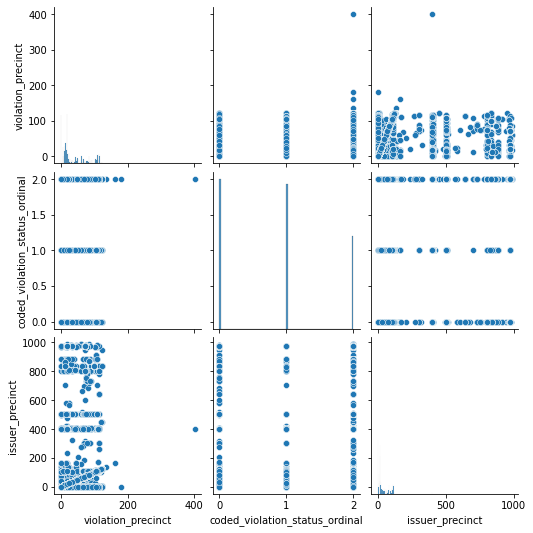

In [14]:
cols = ['violation_time', 'violation', 'violation_precinct', 'coded_violation_status_ordinal', 'issuer_precinct']
sns.pairplot(df[cols])

In [15]:
df.corr()

,violation_code,street_code1,street_code2,violation_location,violation_precinct,issuer_precinct,feet_from_curb,coded_violation_status_ordinal
violation_code,1.000000,0.017413,0.034883,-0.003243,0.048177,0.029137,0.026891,0.109304
street_code1,0.017413,1.000000,0.333250,0.276217,0.367759,0.221047,0.034511,0.042283
street_code2,0.034883,0.333250,1.000000,0.187780,0.260454,0.171909,0.010936,0.039522
violation_location,-0.003243,0.276217,0.187780,1.000000,1.000000,0.615404,0.041237,0.000151
violation_precinct,0.048177,0.367759,0.260454,1.000000,1.000000,0.610525,0.051614,0.042955
issuer_precinct,0.029137,0.221047,0.171909,0.615404,0.610525,1.000000,0.035999,0.054989
feet_from_curb,0.026891,0.034511,0.010936,0.041237,0.051614,0.035999,1.000000,-0.078951
coded_violation_status_ordinal,0.109304,0.042283,0.039522,0.000151,0.042955,0.054989,-0.078951,1.000000


In [343]:
# See pct denied, granted, and reduced by violation
df_pct = df[['violation_code']].join(pd.get_dummies(df.coded_violation_status))

df_pct_g = pd.DataFrame(df_pct.groupby('violation_code').sum())
df_pct_g['total'] = df_pct_g['Denied'] + df_pct_g['Granted'] + df_pct_g['Reduced']
df_pct_g['Denied_pct'] = df_pct_g['Denied'] / df_pct_g['total']
df_pct_g['Granted_pct'] = df_pct_g['Granted'] / df_pct_g['total']
df_pct_g['Reduced_pct'] = df_pct_g['Reduced'] / df_pct_g['total']

# add in violation
df_pct_g = df_pct_g.merge(df[['violation', 'violation_code']], on='violation_code').drop_duplicates()

In [345]:
df_pct_g.sort_values(by='Granted_pct', ascending=False)

,violation_code,Denied,Granted,Reduced,total,Denied_pct,Granted_pct,Reduced_pct,violation
912448,97,0.0,2.0,0.0,2.0,0.000000,1.000000,0.000000,VACANT LOT
912391,90,0.0,2.0,0.0,2.0,0.000000,1.000000,0.000000,VEH-SALE/WSHNG/RPRNG/DRIVEWAY
894384,81,0.0,3.0,0.0,3.0,0.000000,1.000000,0.000000,NO STANDING EXCP DP
394279,34,0.0,1.0,0.0,1.0,0.000000,1.000000,0.000000,EXPIRED METER
378047,28,0.0,1.0,0.0,1.0,0.000000,1.000000,0.000000,OVERTIME STANDING DP
377291,24,9.0,93.0,0.0,102.0,0.088235,0.911765,0.000000,NO PARKING-EXC. AUTH. VEHICLE
378064,30,0.0,10.0,1.0,11.0,0.000000,0.909091,0.090909,NO STOP/STANDNG EXCEPT PAS P/U
378048,29,0.0,14.0,2.0,16.0,0.000000,0.875000,0.125000,ALTERING INTERCITY BUS PERMIT
915154,99,12.0,78.0,1.0,91.0,0.131868,0.857143,0.010989,OTHER
912393,91,6.0,36.0,0.0,42.0,0.142857,0.857143,0.000000,VEHICLE FOR SALE(DEALERS ONLY)


### Feature Engineering

In [17]:
df.columns.values

array(['summons_number', 'plate', 'state', 'license_type', 'issue_date',
       'violation_time', 'violation', 'judgment_entry_date',
       'fine_amount', 'penalty_amount', 'interest_amount',
       'reduction_amount', 'amount_due', 'precinct', 'county',
       'issuing_agency', 'violation_status', 'plate_id', 'plate_type',
       'violation_code', 'vehicle_body_type', 'vehicle_make',
       'street_code1', 'street_code2', 'vehicle_expiration_date',
       'violation_location', 'violation_precinct', 'issuer_precinct',
       'issuer_code', 'issuer_squad', 'time_first_observed',
       'violation_county', 'violation_in_front_of_or_opposite',
       'street_name', 'intersecting_street', 'date_first_observed',
       'law_section', 'sub_division', 'days_parking_in_effect',
       'from_hours_in_effect', 'to_hours_in_effect', 'vehicle_color',
       'vehicle_year', 'meter_number', 'feet_from_curb',
       'violation_post_code', 'violation_description',
       'coded_violation_status', 'co

In [ ]:
df['coded_violation_status'].value_counts(normalize=True)

In [26]:
col = 'vehicle_make'
# col = 'issuer_squad'
display(df[col].nunique())
# display(df[col].describe(datetime_is_numeric=True))
# display(df.loc[df[col].str.contains('lexus')])
display(df[col].value_counts().head(75))
display(df[col].describe())

526

FORD     148640
FRUEH    117533
CHEVR     66839
TOYOT     60497
HONDA     60396
NISSA     49943
INTER     42723
DODGE     35333
ME/BE     33563
HIN       26524
BMW       22694
ISUZU     21832
JEEP      20599
NS/OT     20243
GMC       19237
HYUND     14892
WORKH     13960
LEXUS     13144
ACURA     11334
INFIN      9851
SUBAR      9319
VOLKS      8912
AUDI       8482
KIA        7648
MAZDA      6828
KENWO      6639
CHRYS      6599
MITSU      5728
VOLVO      5528
ROVER      4557
CADIL      3534
PETER      3378
UTILI      2789
LINCO      2771
BUICK      1685
MINI       1675
PORSC      1665
MACK       1327
TESLA      1306
MERCU       952
FIAT        762
JAGUA       752
SMART       741
YAMAH       633
UD          585
PONTI       488
SATUR       447
SUZUK       433
MASE        420
KAWAS       313
NIU         295
SAAB        273
HYUN        252
HARLE       213
VESPA       206
SCION       195
ALFAR       158
FONTA       140
HUMME       126
STERL       112
NAVIS        95
SPRI         85
REVEL   

count     911289
unique       526
top         FORD
freq      148640
Name: vehicle_make, dtype: object

In [75]:
def convert_to_hrs(viol_time):
    if not viol_time:
        return np.nan
    viol_time_parsed = re.findall('(\d+)?:\d+([AP])?', viol_time)[0]
    if viol_time_parsed[1] == '' or int(viol_time_parsed[0]) > 12:
        return np.nan
    if viol_time_parsed[1].upper() == 'P':
        return int(viol_time_parsed[0]) + 12
    elif viol_time_parsed[1].upper() == 'A':
        return int(viol_time_parsed[0])
    else:
        return np.nan

convert_to_hrs('08:07')

nan

In [79]:
# Add weekday, time feature

# Set invalid dates to nan
# df.loc[df['issue_date'] >= '1/28/2022', 'issue_date'] = np.nan
# df.loc[df['issue_date'] < '1/1/2019', 'issue_date'] = np.nan

df['issue_weekday'] = [dt.weekday() for dt in df['issue_date']]
df['violation_hr'] = [convert_to_hrs(t) for t in df['violation_time']]

In [80]:
df['violation_hr'].fillna(-1, inplace=True)
df['issue_weekday'].fillna(-1, inplace=True)

In [142]:
df[['issue_weekday', 'violation_hr']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915245 entries, 0 to 915244
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   issue_weekday  915245 non-null  int64  
 1   violation_hr   915245 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 14.0 MB


In [136]:
df[['issue_weekday', 'violation_hr']].describe()

,issue_weekday,violation_hr
count,915245.000000,915209.000000
mean,2.301061,12.818307
std,1.588354,5.031923
min,0.000000,0.000000
25%,1.000000,9.000000
50%,2.000000,13.000000
75%,4.000000,15.000000
max,6.000000,24.000000


In [266]:
df[['summons_number', 'issue_weekday', 'violation_hr']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915245 entries, 0 to 915244
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   summons_number  915230 non-null  object 
 1   issue_weekday   915245 non-null  float64
 2   violation_hr    915245 non-null  float64
dtypes: float64(2), object(1)
memory usage: 20.9+ MB


In [249]:
df.head()

,summons_number,plate,state,license_type,issue_date,violation_time,violation,judgment_entry_date,fine_amount,penalty_amount,interest_amount,reduction_amount,amount_due,precinct,county,issuing_agency,violation_status,plate_id,plate_type,violation_code,...,violation_county,violation_in_front_of_or_opposite,street_name,intersecting_street,date_first_observed,law_section,sub_division,days_parking_in_effect,from_hours_in_effect,to_hours_in_effect,vehicle_color,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description,coded_violation_status,coded_violation_status_ordinal,issue_weekday,violation_hr
0,8787665803,R98565,MA,COM,2020-08-03,2022-01-30 14:20:00,NO PARKING-DAY/TIME LIMITS,NaT,65.00,0.00,0.00,65.00,0.00,014,NY,TRAFFIC,HEARING HELD-NOT GUILTY,R98565,MA,20.0,...,NY,F,309,None,0,408,I3,None,0800A,0600P,PURPL,None,None,0.0,02,None,Granted,2.0,0.0,14.0
1,8863454061,M87FTP,NJ,PAS,2020-10-22,2022-01-30 12:34:00,FAIL TO DSPLY MUNI METER RECPT,NaT,65.00,0.00,0.00,0.00,65.00,007,NY,TRAFFIC,HEARING HELD-GUILTY,M87FTP,NJ,38.0,...,NY,F,88,None,0,408,C3,None,0900A,0700P,RED,None,None,0.0,034,None,Denied,0.0,3.0,12.0
2,8817303872,AEN5033,NY,PAS,2020-09-02,2022-01-30 12:54:00,BIKE LANE,NaT,115.00,0.00,0.00,0.00,115.00,014,NY,TRAFFIC,HEARING HELD-GUILTY,AEN5033,NY,48.0,...,NY,O,47,None,0,408,D,None,None,None,RD,None,None,0.0,10,None,Denied,0.0,2.0,12.0
3,8818668330,82724MK,NY,COM,2020-09-09,2022-01-30 13:45:00,CROSSWALK,NaT,115.00,0.00,0.00,15.00,100.00,034,NY,TRAFFIC,HEARING HELD-GUILTY REDUCTION,82724MK,NY,50.0,...,NY,I,E,0ft N/of W 207th St,0,408,F1,None,None,None,WH,None,None,0.0,V,None,Reduced,1.0,2.0,13.0
4,8820405787,XGJD27,NJ,PAS,2020-08-04,2022-01-30 08:07:00,FAIL TO DISP. MUNI METER RECPT,NaT,65.00,0.00,0.00,0.00,65.00,014,NY,TRAFFIC,HEARING HELD-GUILTY,XGJD27,NJ,69.0,...,NY,I,N,30ft E/of 5th Ave,0,408,H1,None,0700A,0600P,WHITE,None,None,0.0,21,None,Denied,0.0,1.0,8.0


In [131]:
slice = df[['violation_description', 'violation', 'coded_violation_status_ordinal', 'feet_from_curb']]
slice.loc[slice['feet_from_curb'] >= 12]

,violation_description,violation,coded_violation_status_ordinal,feet_from_curb
22972,None,FIRE HYDRANT,0.0,12
54460,None,FIRE HYDRANT,0.0,12
54666,None,FIRE HYDRANT,0.0,12
65437,None,FIRE HYDRANT,0.0,12
66343,None,FIRE HYDRANT,0.0,12
72533,None,FIRE HYDRANT,0.0,12
114616,None,FIRE HYDRANT,0.0,12
152615,None,FIRE HYDRANT,2.0,12
168922,None,FIRE HYDRANT,0.0,12
170429,None,FIRE HYDRANT,1.0,12


<AxesSubplot:>

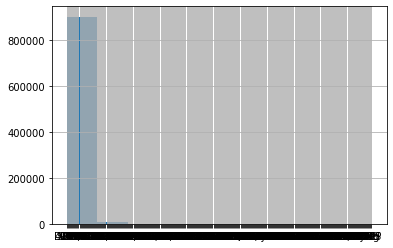

In [68]:
# Visualize
cols = ['violation_time', 'coded_violation_status_ordinal']
# df[cols].plot.scatter('violation_time', 'coded_violation_status_ordinal')
df['vehicle_body_type'].hist()

### Stats to show

In [75]:
# How common is each violation status?
df['coded_violation_status'].value_counts(normalize=True)

Denied     0.386782
Reduced    0.374387
Granted    0.238831
Name: coded_violation_status, dtype: float64

In [7]:
# Analyze outcome by col
cols = ['fine_amount', 'license_type', 'vehicle_body_type_cleaned', 'vehicle_color_cleaned', 
        'vehicle_make', 'violation_code']

def analyze_by_col(df, col):
    analyze_col = df[cols + ["coded_violation_status_ordinal"]].merge(pd.get_dummies(df['coded_violation_status_ordinal']), left_index=True, right_index=True)
    df_analyze_col_g = pd.DataFrame(analyze_col.groupby(col).sum().sort_values(by='fine_amount', ascending=False))
    df_analyze_col_g['totals'] = df_analyze_col_g[0.0] + df_analyze_col_g[1.0] + df_analyze_col_g[2.0]
    df_analyze_col_g['denied_pct'] = df_analyze_col_g[0.0] / df_analyze_col_g['totals'] * 100
    df_analyze_col_g['reduced_pct'] = df_analyze_col_g[1.0] / df_analyze_col_g['totals'] * 100
    df_analyze_col_g['granted_pct'] = df_analyze_col_g[2.0] / df_analyze_col_g['totals'] * 100
    return df_analyze_col_g

def show_statuses(df_g, cutoff=1000):
    display(df_g.loc[df_g['totals'] >= cutoff].sort_values(by='denied_pct', ascending=False))
    display(df_g.loc[df_g['totals'] >= cutoff].sort_values(by='reduced_pct', ascending=False))
    display(df_g.loc[df_g['totals'] >= cutoff].sort_values(by='granted_pct', ascending=False))

In [35]:
# Violation Code
show_statuses(analyze_by_col(df.loc[(df['license_type'] == 'PAS') | (df['license_type'] == 'SRF')], 'violation_code'))

,fine_amount,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
violation_code,,,,,,,,,
40,2967345.0,8355.0,21340.0,571.0,3892.0,25803.0,82.703562,2.212921,15.083517
31,1539505.0,4988.0,10784.0,218.0,2385.0,13387.0,80.555763,1.628446,17.815791
50,573390.0,1947.0,3940.0,145.0,901.0,4986.0,79.021260,2.908143,18.070598
36,1962050.0,10868.0,30973.0,5668.0,2600.0,39241.0,78.930201,14.444076,6.625723
16,1029515.0,4935.0,8347.0,45.0,2445.0,10837.0,77.023161,0.415244,22.561595
51,305620.0,1170.0,2039.0,68.0,551.0,2658.0,76.711813,2.558315,20.729872
53,297620.0,1101.0,1984.0,107.0,497.0,2588.0,76.661515,4.134467,19.204019
21,3326565.0,26770.0,37490.0,620.0,13075.0,51185.0,73.244114,1.211292,25.544593
5,749450.0,5045.0,7994.0,1213.0,1916.0,11123.0,71.869100,10.905331,17.225569


,fine_amount,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
violation_code,,,,,,,,,
69,503165.0,6435.0,3396.0,2315.0,2060.0,7771.0,43.700939,29.790246,26.508815
84,519985.0,6796.0,4024.0,2550.0,2123.0,8697.0,46.268828,29.320455,24.410716
47,665045.0,3388.0,3537.0,1104.0,1142.0,5783.0,61.162027,19.090437,19.747536
10,362135.0,1896.0,1929.0,544.0,676.0,3149.0,61.257542,17.275326,21.467132
12,268450.0,3888.0,1711.0,608.0,1640.0,3959.0,43.217984,15.357413,41.424602
36,1962050.0,10868.0,30973.0,5668.0,2600.0,39241.0,78.930201,14.444076,6.625723
7,186350.0,1619.0,2676.0,483.0,568.0,3727.0,71.800376,12.959485,15.240140
18,243225.0,1294.0,1332.0,272.0,511.0,2115.0,62.978723,12.860520,24.160757
5,749450.0,5045.0,7994.0,1213.0,1916.0,11123.0,71.869100,10.905331,17.225569


,fine_amount,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
violation_code,,,,,,,,,
38,2978525.0,93822.0,24330.0,1160.0,46331.0,71821.0,33.875886,1.615126,64.508988
74,1645735.0,32823.0,8734.0,347.0,16238.0,25319.0,34.495833,1.370512,64.133655
37,722880.0,20250.0,6726.0,318.0,9966.0,17010.0,39.541446,1.869489,58.589065
71,358800.0,6226.0,2406.0,2.0,3112.0,5520.0,43.586957,0.036232,56.376812
98,238325.0,2612.0,1200.0,6.0,1303.0,2509.0,47.827820,0.239139,51.933041
70,345865.0,5466.0,2588.0,0.0,2733.0,5321.0,48.637474,0.000000,51.362526
75,98540.0,1529.0,751.0,1.0,764.0,1516.0,49.538259,0.065963,50.395778
12,268450.0,3888.0,1711.0,608.0,1640.0,3959.0,43.217984,15.357413,41.424602
68,79470.0,907.0,862.0,17.0,445.0,1324.0,65.105740,1.283988,33.610272


In [10]:
show_statuses(analyze_by_col(df.loc[(df['license_type'] == 'PAS') | (df['license_type'] == 'SRF')], 'vehicle_make'))

,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_make,,,,,,,,,,
MINI,124210.0,55221,1060.0,1079.0,10.0,525.0,1614.0,66.852540,0.619579,32.527881
VOLKS,645653.0,288018,5599.0,5761.0,139.0,2730.0,8630.0,66.755504,1.610660,31.633835
TESLA,86290.0,39940,821.0,802.0,9.0,406.0,1217.0,65.899753,0.739523,33.360723
HYUND,1018650.0,450139,8996.0,9059.0,384.0,4306.0,13749.0,65.888428,2.792930,31.318641
MAZDA,486530.0,222299,4418.0,4345.0,88.0,2165.0,6598.0,65.853289,1.333737,32.812974
HIN,791565.0,338922,4893.0,5384.0,859.0,2017.0,8260.0,65.181598,10.399516,24.418886
KIA,543300.0,236863,4966.0,4747.0,200.0,2383.0,7330.0,64.761255,2.728513,32.510232
BMW,1579505.0,781287,14947.0,14112.0,499.0,7224.0,21835.0,64.630181,2.285322,33.084497
HONDA,4111360.0,1872815,38634.0,36144.0,996.0,18819.0,55959.0,64.590146,1.779875,33.629979


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_make,,,,,,,,,,
INTER,1131715.0,533663,10680.0,4997.0,3432.0,3624.0,12053.0,41.458558,28.474239,30.067203
FRUEH,2146745.0,955750,17400.0,10727.0,5936.0,5732.0,22395.0,47.899085,26.505916,25.594999
ISUZU,427925.0,171234,2736.0,2795.0,526.0,1105.0,4426.0,63.149571,11.884320,24.966109
CHEVR,1496730.0,696011,15035.0,11227.0,2079.0,6478.0,19784.0,56.747877,10.508492,32.743631
HIN,791565.0,338922,4893.0,5384.0,859.0,2017.0,8260.0,65.181598,10.399516,24.418886
FORD,2771110.0,1256173,26650.0,20752.0,2918.0,11866.0,35536.0,58.397118,8.211391,33.391490
DODGE,1161295.0,535142,12977.0,8055.0,1151.0,5913.0,15119.0,53.277333,7.612937,39.109729
NS/OT,382740.0,189082,5863.0,1381.0,315.0,2774.0,4470.0,30.894855,7.046980,62.058166
GMC,392095.0,208110,4142.0,3101.0,296.0,1923.0,5320.0,58.289474,5.563910,36.146617


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_make,,,,,,,,,,
NS/OT,382740.0,189082,5863.0,1381.0,315.0,2774.0,4470.0,30.894855,7.046980,62.058166
DODGE,1161295.0,535142,12977.0,8055.0,1151.0,5913.0,15119.0,53.277333,7.612937,39.109729
LEXUS,858900.0,418605,9486.0,7561.0,204.0,4641.0,12406.0,60.946316,1.644366,37.409318
VOLVO,394210.0,181223,3655.0,3028.0,87.0,1784.0,4899.0,61.808532,1.775873,36.415595
PORSC,114515.0,56558,1171.0,1005.0,13.0,579.0,1597.0,62.930495,0.814026,36.255479
GMC,392095.0,208110,4142.0,3101.0,296.0,1923.0,5320.0,58.289474,5.563910,36.146617
ROVER,305170.0,145153,3110.0,2676.0,58.0,1526.0,4260.0,62.816901,1.361502,35.821596
TOYOT,3318915.0,1511344,33873.0,28191.0,1413.0,16230.0,45834.0,61.506742,3.082864,35.410394
CHRYS,435130.0,202967,4466.0,3754.0,168.0,2149.0,6071.0,61.834953,2.767254,35.397793


In [36]:
df['vehicle_make'].value_counts().head(99)

FORD     148640
FRUEH    117533
CHEVR     66839
TOYOT     60497
HONDA     60396
NISSA     49943
INTER     42723
DODGE     35333
ME/BE     33563
HIN       26524
BMW       22694
ISUZU     21832
JEEP      20599
NS/OT     20243
GMC       19237
HYUND     14892
WORKH     13960
LEXUS     13144
ACURA     11334
INFIN      9851
SUBAR      9319
VOLKS      8912
AUDI       8482
KIA        7648
MAZDA      6828
KENWO      6639
CHRYS      6599
MITSU      5728
VOLVO      5528
ROVER      4557
CADIL      3534
PETER      3378
UTILI      2789
LINCO      2771
BUICK      1685
MINI       1675
PORSC      1665
MACK       1327
TESLA      1306
MERCU       952
FIAT        762
JAGUA       752
SMART       741
YAMAH       633
UD          585
PONTI       488
SATUR       447
SUZUK       433
MASE        420
KAWAS       313
NIU         295
SAAB        273
HYUN        252
HARLE       213
VESPA       206
SCION       195
ALFAR       158
FONTA       140
HUMME       126
STERL       112
NAVIS        95
SPRI         85
REVEL   

In [21]:
show_statuses(analyze_by_col(df.loc[(df['license_type'] == 'PAS') | (df['license_type'] == 'SRF')], 'vehicle_color_cleaned'))

,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
GR,413690.0,203735,4073.0,3718.0,103.0,1985.0,5806.0,64.037203,1.774027,34.188770
BK,7076480.0,3287508,66994.0,61502.0,2176.0,32409.0,96087.0,64.006577,2.264614,33.728808
MR,81645.0,41045,841.0,751.0,35.0,403.0,1189.0,63.162321,2.943650,33.894029
TN,360120.0,172840,3566.0,3161.0,152.0,1707.0,5020.0,62.968127,3.027888,34.003984
GY,8530928.0,3925881,83265.0,72882.0,3085.0,40090.0,116057.0,62.798452,2.658177,34.543371
RD,1876880.0,854313,17444.0,15433.0,864.0,8290.0,24587.0,62.768943,3.514052,33.717005
BR,288490.0,134544,2872.0,2482.0,88.0,1392.0,3962.0,62.645129,2.221100,35.133771
BL,2897485.0,1367665,28557.0,24203.0,1145.0,13706.0,39054.0,61.973165,2.931838,35.094997
GL,233320.0,108279,2357.0,1936.0,61.0,1148.0,3145.0,61.558029,1.939587,36.502385


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
GN,408155.0,168316,3421.0,2030.0,1357.0,1032.0,4419.0,45.937995,30.708305,23.353700
WH,10533505.0,4873500,98724.0,72186.0,15036.0,41844.0,129066.0,55.929524,11.649854,32.420622
OR,127360.0,58117,1230.0,874.0,142.0,544.0,1560.0,56.025641,9.102564,34.871795
OTHER,298680.0,126599,2782.0,2091.0,264.0,1259.0,3614.0,57.858329,7.304925,34.836746
RD,1876880.0,854313,17444.0,15433.0,864.0,8290.0,24587.0,62.768943,3.514052,33.717005
TN,360120.0,172840,3566.0,3161.0,152.0,1707.0,5020.0,62.968127,3.027888,34.003984
MR,81645.0,41045,841.0,751.0,35.0,403.0,1189.0,63.162321,2.943650,33.894029
BL,2897485.0,1367665,28557.0,24203.0,1145.0,13706.0,39054.0,61.973165,2.931838,35.094997
GY,8530928.0,3925881,83265.0,72882.0,3085.0,40090.0,116057.0,62.798452,2.658177,34.543371


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
YW,544190.0,217440,5014.0,3466.0,102.0,2456.0,6024.0,57.536521,1.693227,40.770252
GL,233320.0,108279,2357.0,1936.0,61.0,1148.0,3145.0,61.558029,1.939587,36.502385
BR,288490.0,134544,2872.0,2482.0,88.0,1392.0,3962.0,62.645129,2.221100,35.133771
BL,2897485.0,1367665,28557.0,24203.0,1145.0,13706.0,39054.0,61.973165,2.931838,35.094997
OR,127360.0,58117,1230.0,874.0,142.0,544.0,1560.0,56.025641,9.102564,34.871795
OTHER,298680.0,126599,2782.0,2091.0,264.0,1259.0,3614.0,57.858329,7.304925,34.836746
GY,8530928.0,3925881,83265.0,72882.0,3085.0,40090.0,116057.0,62.798452,2.658177,34.543371
GR,413690.0,203735,4073.0,3718.0,103.0,1985.0,5806.0,64.037203,1.774027,34.188770
TN,360120.0,172840,3566.0,3161.0,152.0,1707.0,5020.0,62.968127,3.027888,34.003984


In [12]:
show_statuses(analyze_by_col(df.loc[(df['license_type'] == 'PAS') | (df['license_type'] == 'SRF')], 'vehicle_body_type_cleaned'))

,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_body_type_cleaned,,,,,,,,,,
SWT,52070.0,27888,439.0,710.0,169.0,135.0,1014.0,70.019724,16.666667,13.313609
UTIL,223230.0,84317,1597.0,2351.0,619.0,489.0,3459.0,67.967621,17.895345,14.137034
4DSD,10211130.0,4630644,86894.0,92647.0,3062.0,41916.0,137625.0,67.318438,2.224886,30.456676
2DSD,892060.0,439455,7767.0,8018.0,203.0,3782.0,12003.0,66.799967,1.691244,31.508789
CONV,184415.0,97442,1701.0,1699.0,57.0,822.0,2578.0,65.903801,2.211016,31.885182
TRAC,1027940.0,499960,5744.0,6922.0,2094.0,1825.0,10841.0,63.850198,19.315561,16.834240
SUBN,13840345.0,6503571,142567.0,118764.0,4167.0,69200.0,192131.0,61.814075,2.168833,36.017093
DELV,3064065.0,1320061,24460.0,17233.0,5268.0,9596.0,32097.0,53.690376,16.412749,29.896875
SEDN,1079123.0,463845,12553.0,7395.0,493.0,6030.0,13918.0,53.132634,3.542176,43.325190


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_body_type_cleaned,,,,,,,,,,
REFG,636900.0,296404,5388.0,2578.0,2832.0,1278.0,6688.0,38.546651,42.344498,19.108852
VAN,1709665.0,782827,18612.0,8838.0,3900.0,7356.0,20094.0,43.983279,19.408779,36.607943
TRAC,1027940.0,499960,5744.0,6922.0,2094.0,1825.0,10841.0,63.850198,19.315561,16.834240
PICK,833920.0,422144,9304.0,5577.0,2060.0,3622.0,11259.0,49.533706,18.296474,32.169820
TR/C,121020.0,49706,2019.0,125.0,227.0,896.0,1248.0,10.016026,18.189103,71.794872
UTIL,223230.0,84317,1597.0,2351.0,619.0,489.0,3459.0,67.967621,17.895345,14.137034
SWT,52070.0,27888,439.0,710.0,169.0,135.0,1014.0,70.019724,16.666667,13.313609
DELV,3064065.0,1320061,24460.0,17233.0,5268.0,9596.0,32097.0,53.690376,16.412749,29.896875
TRLR,267940.0,152816,4816.0,512.0,344.0,2236.0,3092.0,16.558862,11.125485,72.315653


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_body_type_cleaned,,,,,,,,,,
TRLR,267940.0,152816,4816.0,512.0,344.0,2236.0,3092.0,16.558862,11.125485,72.315653
TR/C,121020.0,49706,2019.0,125.0,227.0,896.0,1248.0,10.016026,18.189103,71.794872
SEDN,1079123.0,463845,12553.0,7395.0,493.0,6030.0,13918.0,53.132634,3.542176,43.325190
VAN,1709665.0,782827,18612.0,8838.0,3900.0,7356.0,20094.0,43.983279,19.408779,36.607943
SUBN,13840345.0,6503571,142567.0,118764.0,4167.0,69200.0,192131.0,61.814075,2.168833,36.017093
PICK,833920.0,422144,9304.0,5577.0,2060.0,3622.0,11259.0,49.533706,18.296474,32.169820
CONV,184415.0,97442,1701.0,1699.0,57.0,822.0,2578.0,65.903801,2.211016,31.885182
2DSD,892060.0,439455,7767.0,8018.0,203.0,3782.0,12003.0,66.799967,1.691244,31.508789
4DSD,10211130.0,4630644,86894.0,92647.0,3062.0,41916.0,137625.0,67.318438,2.224886,30.456676


In [21]:
# By Vehicle Make and color
vehicle_make = 'TESLA'
show_statuses(analyze_by_col(df.loc[((df['license_type'] == 'PAS') | (df['license_type'] == 'SRF')) & 
                                   (df['vehicle_make'] == vehicle_make)], 'vehicle_color_cleaned'), cutoff=10)

,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
GY,22960.0,10602,209.0,215,1,104,64,335.937500,1.562500,162.500000
BK,24655.0,11102,205.0,238,3,101,86,276.744186,3.488372,117.441860
WH,24430.0,11211,256.0,211,2,127,84,251.190476,2.380952,151.190476
BL,7715.0,3715,74.0,76,0,37,113,67.256637,0.000000,32.743363
RD,4305.0,2273,53.0,38,1,26,65,58.461538,1.538462,40.000000


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
BK,24655.0,11102,205.0,238,3,101,86,276.744186,3.488372,117.441860
WH,24430.0,11211,256.0,211,2,127,84,251.190476,2.380952,151.190476
GY,22960.0,10602,209.0,215,1,104,64,335.937500,1.562500,162.500000
RD,4305.0,2273,53.0,38,1,26,65,58.461538,1.538462,40.000000
BL,7715.0,3715,74.0,76,0,37,113,67.256637,0.000000,32.743363


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
GY,22960.0,10602,209.0,215,1,104,64,335.937500,1.562500,162.500000
WH,24430.0,11211,256.0,211,2,127,84,251.190476,2.380952,151.190476
BK,24655.0,11102,205.0,238,3,101,86,276.744186,3.488372,117.441860
RD,4305.0,2273,53.0,38,1,26,65,58.461538,1.538462,40.000000
BL,7715.0,3715,74.0,76,0,37,113,67.256637,0.000000,32.743363


In [20]:
# By Vehicle Make and Body Type
vehicle_make = 'FORD'
vehicle_bt = 'SEDN'
col_g = 'vehicle_color_cleaned'
show_statuses(analyze_by_col(df.loc[((df['license_type'] == 'PAS') | (df['license_type'] == 'SRF')) & 
                                   (df['vehicle_make'] == vehicle_make) & (df['vehicle_body_type_cleaned'] == vehicle_bt)], 
                             col_g), cutoff=10)

,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
RD,2770.0,1088,28.0,20,0,14,34,58.823529,0.000000,41.176471
BL,3755.0,1719,46.0,24,0,23,47,51.063830,0.000000,48.936170
WH,6600.0,2844,83.0,37,1,41,79,46.835443,1.265823,51.898734
GY,10835.0,4138,141.0,54,1,70,125,43.200000,0.800000,56.000000
BK,9260.0,3902,124.0,44,0,62,106,41.509434,0.000000,58.490566


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
WH,6600.0,2844,83.0,37,1,41,79,46.835443,1.265823,51.898734
GY,10835.0,4138,141.0,54,1,70,125,43.200000,0.800000,56.000000
BK,9260.0,3902,124.0,44,0,62,106,41.509434,0.000000,58.490566
BL,3755.0,1719,46.0,24,0,23,47,51.063830,0.000000,48.936170
RD,2770.0,1088,28.0,20,0,14,34,58.823529,0.000000,41.176471


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
BK,9260.0,3902,124.0,44,0,62,106,41.509434,0.000000,58.490566
GY,10835.0,4138,141.0,54,1,70,125,43.200000,0.800000,56.000000
WH,6600.0,2844,83.0,37,1,41,79,46.835443,1.265823,51.898734
BL,3755.0,1719,46.0,24,0,23,47,51.063830,0.000000,48.936170
RD,2770.0,1088,28.0,20,0,14,34,58.823529,0.000000,41.176471


In [9]:
# Load xgb model
with open(fp + '6_feats_xgb_final.pkl', 'rb') as f:
    xgb_top_six = dill.load(f)
xgb_top_six

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['fine_amount']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['license_type',
                                                   'vehicle_body_type_cleaned',
                                                   'vehicle_color_cleaned',
                                                   'vehicle_make',
                                                   'violation_code'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbt...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

### Pipeline

In [9]:
X = df.drop(columns='coded_violation_status_ordinal')
# X = df[['violation_code', 'county', 'issuer_squad', 'vehicle_make', 'fine_amount']]
y = df['coded_violation_status_ordinal']

In [10]:
# Prep for col transformer
drop_cols = ['summons_number', 'plate', 'plate_id', 'plate_type', 'violation_status', 'street_code1', 'street_code2',
            'precinct', 'issuer_code', 'county', 'street_name', 'intersecting_street', 'sub_division', 'days_parking_in_effect',
            'meter_number', 'violation_post_code', 'violation_description', 'reduction_amount', 'amount_due']
# If wanted to hash each col, use a list comp to generate 
hash_cols = ['state', 'license_type', 'violation_code', 'precinct', 'vehicle_body_type_cleaned', 'vehicle_make', 'issuer_squad',
            'vehicle_color_cleaned']
ohe_cols = ['violation_in_front_of_or_opposite', 'law_section', 'county', 'issuing_agency', 'from_hours_in_effect', 
            'to_hours_in_effect', 'violation_location']
dt_cols = ['issue_weekday',  'violation_hr']
# float_cols = ['fine_amount', 'penalty_amount', 'interest_amount', 'reduction_amount', 'amount_due']
# pass_cols = ['feet_from_curb', 'fine_amount'] #, 'interest_amount', 'penalty_amount'
pass_cols = ['fine_amount'] #, 'issue_weekday',  'violation_hr' 
test_cat_cols = ['violation_code', 'county', 'issuer_squad', 'vehicle_make']
top_cat_cols = ['license_type', 'vehicle_body_type_cleaned', 'vehicle_color_cleaned', 'vehicle_make', 'violation_code']

In [11]:
# all_cat_cols = ohe_cols.copy()
# all_cat_cols.extend(hash_cols)
all_cat_cols = ohe_cols + hash_cols
all_cat_cols

['violation_in_front_of_or_opposite',
 'law_section',
 'county',
 'issuing_agency',
 'from_hours_in_effect',
 'to_hours_in_effect',
 'violation_location',
 'state',
 'license_type',
 'violation_code',
 'precinct',
 'vehicle_body_type',
 'vehicle_make',
 'issuer_squad',
 'vehicle_color_cleaned']

In [12]:
# Train Test Split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
pass_cols + top_cat_cols

['fine_amount',
 'license_type',
 'vehicle_body_type_cleaned',
 'vehicle_color_cleaned',
 'vehicle_make',
 'violation_code']

In [76]:
# Pipeline and Column Transformer
features = ColumnTransformer(
    transformers=[
    # ('simple_imputer_num', SimpleImputer(), pass_cols),
    # ('simple_imputer_cat', SimpleImputer(strategy='constant', fill_value=-1), top_cat_cols),
    # ('hash', FeatureHasher(input_type='string'), 'state'),
    ('scale_numeric', StandardScaler(), pass_cols),
    # ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'), all_cat_cols)
    # ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'), top_cat_cols)
    # ('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), all_cat_cols)
    ('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), top_cat_cols)
    # ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'), test_cat_cols)
])

pipe = Pipeline([
    ('features', features),
    # ('pca', PCA(n_components=5)),
    # ('log_reg', LogisticRegression(max_iter=1000, solver='sag', C=1))
    # ('log_reg', LogisticRegression())
    # best log reg params for top 6 features
    # ('log_reg', LogisticRegression(solver='sag', penalty='none',
    #                               max_iter=300, C=1))
    # ('log_reg', LogisticRegression(solver='sag', penalty='none',
    #                                max_iter=200))
    # ('rf', RandomForestClassifier(n_estimators=800, max_features='auto', 
    #                               max_depth=8, criterion='entropy'))
    # ('linearSVC', LinearSVC(C=1))
    # ('bnb', BernoulliNB())
    # ('gb', GradientBoostingClassifier())
    # ('gb', GradientBoostingClassifier(subsample=0.8, min_samples_split=0.5,
    #                                  max_features=None, max_depth=8,
    #                                  learning_rate=0.2))
    # ('xgb', xgb.XGBClassifier(use_label_encoder=False))
    ('xgb', xgb.XGBClassifier(#subsample=0.9, max_depth=8, #eta=0.2, gamma=0.275,
                              use_label_encoder=False))
])


In [45]:
# Randomized Search CV
params_lr = {'log_reg__C': [0.01, 0.1, 1, 10, 100, 1000],
            'log_reg__solver': ['sag', 'saga'],
             'log_reg__penalty': ['l2', 'none'],
             'log_reg__max_iter': [100, 200, 300, 400]}  # from randomizedsearchcv, we know C=1 is best
param_grid_rf = { 
    'rf__n_estimators': [200, 500, 800],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'rf__criterion': ['gini', 'entropy']
}

param_grid_nb = { 
    'bnb__binarize': [None, 1, 2, 3, 4, 5]
}

param_grid_gb = {
    "gb__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "gb__min_samples_split": np.linspace(0.1, 0.5, 12),
    "gb__max_depth":[3,5,8,10,12],
    "gb__max_features":["log2", "sqrt", None],
    "gb__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]}

param_grid_xgb = {
    # "xgb__eta": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    # "xgb__gamma": np.linspace(0.1, 0.5, 12),
    # "xgb__max_depth":[3,5,8,10],
    # "xgb__subsample":[.25, 0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]}
    "pca__n_components": [5, 10, 15, 20, 25, 30],
    "xgb__eta": [0.15, 0.2],
    "xgb__gamma": np.linspace(0.05, 0.275, 4),
    "xgb__max_depth":[6,8,10],
    "xgb__subsample":[0.85, 0.9]}
# gs_est = GridSearchCV(pipe, param_grid_rf, cv=3, n_jobs=-3, verbose=1)
rs_est = RandomizedSearchCV(pipe, param_grid_xgb, cv=3, n_jobs=-3, verbose=1)
# Run PCA to minimize features, have things to input for website
# Naive bayes, if chose right version of naive bayes, may not even need to ohe
# rf for smaller parts of data, could try ordinal encoding since rf isn't sensitive to ordinal encoding, don't need to scale


In [79]:
# gs_est.fit(X_train[:10000], y_train[:10000])
# rs_est.fit(X_train[:500000], y_train[:500000])
# pipe.fit(X_train[:500000], y_train[:500000])

# pipe.fit(X_train[:9000], y_train[:9000])
# gs_est.fit(X_train[:90000], y_train[:90000])

# On all data
pipe.fit(X_train, y_train)
# rs_est.fit(X_train, y_train)

[01:31:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['fine_amount']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['license_type',
                                                   'vehicle_body_type_cleaned',
                                                   'vehicle_color_cleaned',
                                                   'vehicle_make',
                                                   'violation_code'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbt...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [222]:
# Pickle model
# pickle.dump(pipe, open(fp + 'log_reg_5_feats.pkl', 'wb'))
pickle.dump(pipe, open(fp + '6_feats_xgb_final.pkl', 'wb'))

In [221]:
pipe.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['fine_amount']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['license_type',
                                                   'vehicle_body_type_cleaned',
                                                   'vehicle_color_cleaned',
                                                   'vehicle_make',
                                                   'violation_code'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbt...
                

In [407]:
# with logistic reg score: 0.7405643060678636 on test, 0.74039 on train (w/o hyperparameter tuning)
# w/ rs: 0.7401272660524798
# w/ solver=sag: 0.7401534884534028
# 0.7404463052637099 w/ hr and weekday added
# 0.7404594164641715 w/ additional rs params
# 0.7384184395923291 after cleaning vehicle color w/o hr and weekday
# 0.7392400748212506 added 3 more features from, to_hours, viol_location
# 0.7397820044403266 cleaned vehicle body

# 0.7004046990542454 w/ top 5 features
# 0.6989930598045557 w/ top 5 feats after data cleaning
# 0.7313820953446497 w/ top 6 feats
# 0.7300753456986522 w/ top 6 feats and cleaned cols
# 0.7284408160411168 w/ top 6 feats and cleaned cols after rs again

# best params
# {'log_reg__solver': 'saga',
#  'log_reg__penalty': 'none',
#  'log_reg__max_iter': 100,
#  'log_reg__C': 1000}

# {'log_reg__solver': 'sag',
#  'log_reg__penalty': 'none',
#  'log_reg__max_iter': 200,
#  'log_reg__C': 0.01}

# {'log_reg__solver': 'saga',
#  'log_reg__penalty': 'l2',
#  'log_reg__max_iter': 100,
#  'log_reg__C': 1000}

# for 5 features
# {'log_reg__solver': 'sag',
#  'log_reg__penalty': 'l2',
#  'log_reg__max_iter': 300,
#  'log_reg__C': 100}

# for 6 features
# {'log_reg__solver': 'sag',
#  'log_reg__penalty': 'none',
#  'log_reg__max_iter': 300,
#  'log_reg__C': 1}
pipe.score(X_test, y_test)

0.7284582976417321

In [51]:
rs_est.best_params_

{'xgb__subsample': 0.9,
 'xgb__max_depth': 12,
 'xgb__gamma': 0.275,
 'xgb__eta': 0.15,
 'pca__n_components': 5}

[01:10:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:10:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:10:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [218]:
# 0.7576176074681398 with xgboost classifier on 6 fts
# 0.7701431743090398 with all cat feats (no dt)
# 0.7747583168714928 moved max depth from 10 to 12, might be some overfitting
# 0.7573816058598325 with pca and more rs on 6 feats, definitely overfitting
# 0.7556 on test, 0.7679 on train with pca, higher eta, 
# 0.744877 on test, 0.7501 on train with pca, default xgb

# best params for 6 fts
# {'xgb__subsample': 0.9, 'xgb__max_depth': 10,
#  'xgb__gamma': 0.2090909090909091, 'xgb__eta': 0.15}

# {'xgb__subsample': 0.85,
#  'xgb__max_depth': 12,
#  'xgb__gamma': 0.25,
#  'xgb__eta': 0.2}

# with PCA
# {'xgb__subsample': 0.9,
#  'xgb__max_depth': 12,
#  'xgb__gamma': 0.275,
#  'xgb__eta': 0.15,
#  'pca__n_components': 5}

# rs_est.score(X_test, y_test)
pipe.score(X_test, y_test)

0.7509920808349212

In [217]:
pipe.score(X_train, y_train)

0.7541755713958973

In [24]:
# 0.7413422372952467 with GradientBoostedClassifier
# 0.7406254916700173 with rs
# 0.7453105606349317 with rs
# 0.6601489432372428 with 5 features
# 0.6682735171232278 after rs with 5 feats
# 0.7221605510200514 with 6 fts and 2 cols cleaned
# 0.7346336730591053 with 6 fts after rs again
rs_est.score(X_test, y_test)
# pipe.score(X_test, y_test)

0.7346336730591053

In [176]:
# for GB with 5 feats
# {'gb__subsample': 0.8,
#  'gb__min_samples_split': 0.5,
#  'gb__max_features': None,
#  'gb__max_depth': 8,
#  'gb__learning_rate': 0.2}

# for GB with all_cat_cols
# {'gb__subsample': 0.9,
#  'gb__min_samples_split': 0.17272727272727273,
#  'gb__max_features': None,
#  'gb__max_depth': 5,
#  'gb__learning_rate': 0.15}

# for GB with 6 feats, cleaned
# {'gb__subsample': 0.9,
#  'gb__min_samples_split': 0.1,
#  'gb__max_features': None,
#  'gb__max_depth': 8,
#  'gb__learning_rate': 0.05}

rs_est.best_params_

{'log_reg__solver': 'saga',
 'log_reg__penalty': 'none',
 'log_reg__max_iter': 100,
 'log_reg__C': 1000}

In [191]:
# for 55%
# {'rf__n_estimators': 200,
#  'rf__max_features': 'auto',
#  'rf__max_depth': 7,
#  'rf__criterion': 'entropy'}
rs_est.best_params_

{'rf__n_estimators': 800,
 'rf__max_features': 'auto',
 'rf__max_depth': 8,
 'rf__criterion': 'entropy'}

In [70]:
# for 40%
rs_est.best_params_

{'rf__n_estimators': 500,
 'rf__max_features': 'auto',
 'rf__max_depth': 7,
 'rf__criterion': 'entropy'}

In [67]:
# for 20%
rs_est.best_params_

{'rf__n_estimators': 200,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 8,
 'rf__criterion': 'gini'}

In [95]:
# naive bayes, proba not a fair metric to use bc assumes all of coefs unrelated
# 0.6780675838679789 with BernoulliNB
# with BernoulliNB and randomized search CV
rs_est.score(X_test, y_test)

0.43969721867734207

In [17]:
# linearSVC 0.7374525811583309 w/o grid search, 0.7381168819817142 w/ randomized search
# gs_est.score(X_test, y_test)
pipe.score(X_test, y_test)

0.6652841634180026

In [76]:
ypred = rs_est.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

         0.0       0.60      0.84      0.70     88428
         1.0       0.76      0.91      0.83     85732
         2.0       0.86      0.04      0.09     54652

    accuracy                           0.68    228812
   macro avg       0.74      0.60      0.54    228812
weighted avg       0.72      0.68      0.60    228812



In [364]:
# Check for overfitting
pipe.score(X_train, y_train)

0.7313445012113345

In [ ]:
# SVM -> rbf is like knn
# Try something non-linear like random forest, change small forest

In [42]:
# with random forest score: 0.7311198713354194 training on 1% of data
# 0.753102984109225 training on 10% of data
# 0.68 with randomizedsearchCV on 10%
# 0.679334999912592 with randomizedsearchCV on 20%
# 0.6776436550530567 with randomizedsearchCV on 40%
# 0.6760571997972135 with randomizedsearchCV on 55%
# 0.7160376204045242 with randomizedsearchCV on 55%, ordinalencoded
#  with randomizedsearchCV on all
# rs_est.score(X_test, y_test)
pipe.score(X_test, y_test)

0.7159021379997552

In [43]:
# Feature weight from random forest
pipe['rf'].feature_importances_

array([0.05136629, 0.00234954, 0.00619777, 0.00844718, 0.00665464,
       0.00623323, 0.02773856, 0.39922043, 0.0428967 , 0.03090327,
       0.20677015, 0.0709556 , 0.02589846, 0.11436818])

In [46]:
pass_cols

['fine_amount',
 'violation_in_front_of_or_opposite',
 'law_section',
 'county',
 'issuing_agency',
 'law_section',
 'state',
 'license_type',
 'violation_code',
 'precinct',
 'vehicle_body_type',
 'vehicle_make',
 'issuer_squad',
 'vehicle_color']

In [172]:
# Analyze license type
li_type_g = pd.DataFrame(df[['license_type', 'coded_violation_status_ordinal', 'summons_number']].groupby(by=['license_type', 
                                                                                     'coded_violation_status_ordinal']).count())


In [174]:
li_type_g.head(90)

summons_number
license_type coded_violation_status_ordinal                
999          0.0                                       1325
             1.0                                         38
             2.0                                       1531
AGC          0.0                                          1
             2.0                                          1
AGR          0.0                                         12
             1.0                                         17
             2.0                                          3
AMB          0.0                                          5
             1.0                                          9
             2.0                                        100
APP          0.0                                       2852
             1.0                                       2585
             2.0                                       1234
ATV          0.0                                          2
             2.0                                          5
AYG          0.0                                          5
             2.0                                          3
BOB          0.0                                          6
             2.0                                          7
BOT          2.0                                          3
CHC          0.0                                         32
             2.0                                         29
CMB          0.0                                        237
             1.0                                        201
             2.0                                        332
COM          0.0                                      52630
             1.0                                     309546
             2.0                                      41569
CSP          2.0                                          2
DLR          0.0                                         48
             2.0                                         54
GSM          2.0                                          2
HAM          0.0                                          3
             2.0                                          3
HIS          0.0                                         39
             2.0                                         51
HOU          2.0                                          1
IRP          0.0                                         52
             1.0                                         69
             2.0                                         48
ITP          0.0                                         93
             2.0                                         86
JCL          0.0                                          1
LMA          0.0                                          5
             2.0                                         33
LMB          0.0                                       1558
             2.0                                       6339
LMC          0.0                                          5
             2.0                                        312
LTR          0.0                                          1
MCD          2.0                                          4
MCL          0.0                                          8
             2.0                                        186
MED          0.0                                        424
             1.0                                         11
             2.0                                        288
MOT          0.0                                        705
             1.0                                         27
             2.0                                       4325
NLM          0.0                                          8
             2.0                                          6
NYA          0.0                                          2
             2.0                                          1
NYC          2.0                                          1
NYS          0.0         

In [7]:
df['vehicle_color'].value_counts()

WH       223997
WHITE    159201
BROWN    101629
GY        96628
BK        85898
          ...  
TN/           1
PEARL         1
MN.           1
BF            1
WHAT          1
Name: vehicle_color, Length: 396, dtype: int64

In [60]:
feat_imp = list(zip(pass_cols + all_cat_cols, pipe['rf'].feature_importances_))
feat_imp = sorted(feat_imp, key = lambda x: x[1], reverse=True)
feat_imp

[('license_type', 0.399220425736844),
 ('vehicle_body_type', 0.2067701540468146),
 ('vehicle_color', 0.11436817927232823),
 ('vehicle_make', 0.07095560223523363),
 ('fine_amount', 0.05136629097418679),
 ('violation_code', 0.04289669543089667),
 ('precinct', 0.030903268025916645),
 ('state', 0.02773856469763376),
 ('issuer_squad', 0.02589846188449965),
 ('county', 0.008447179541564152),
 ('issuing_agency', 0.006654642987936351),
 ('law_section', 0.006233227907290224),
 ('law_section', 0.0061977693822357054),
 ('violation_in_front_of_or_opposite', 0.0023495378766195977)]

In [138]:
# Test out col trans
features.transform(X_train[:5])

array([[ -1.19330083,  38.        ,  63.        , 103.        ,
        166.        ,  75.        ],
       [  1.01628129,  11.        ,  63.        , 195.        ,
        135.        ,  12.        ],
       [  1.01628129,  38.        , 161.        ,  35.        ,
        362.        ,  45.        ],
       [ -0.56199165,  11.        ,  63.        ,  50.        ,
        166.        ,  37.        ],
       [  1.01628129,  11.        , 199.        ,  50.        ,
        166.        ,  41.        ]])

In [139]:
features.named_transformers_['ordinal_encode'].categories_

[array(['999', 'AGC', 'AGR', 'AMB', 'APP', 'ATV', 'AYG', 'BOB', 'BOT',
        'CHC', 'CMB', 'COM', 'CSP', 'DLR', 'GSM', 'HAM', 'HIS', 'HOU',
        'IRP', 'ITP', 'LMA', 'LMB', 'LMC', 'LTR', 'MCD', 'MCL', 'MED',
        'MOT', 'NLM', 'NYA', 'NYC', 'NYS', 'OML', 'OMR', 'OMS', 'OMT',
        'ORC', 'ORG', 'PAS', 'PHS', 'PSD', 'RGC', 'RGL', 'SCL', 'SEM',
        'SNO', 'SOS', 'SPC', 'SPO', 'SRF', 'SRN', 'STA', 'STG', 'TOW',
        'TRA', 'TRC', 'TRL', 'VAS'], dtype=object),
 array(['00', '2DSD', '2H', '2L', '2S', '2W', '3D', '3P', '4 DO', '4C',
        '4DSD', '4H', '4HB', '4P', '4SLE', '4SXS', '4W', '4WHE', '5D',
        '5H', 'A', 'AA', 'ADS', 'AEL', 'ALO', 'ALWL', 'AMBU', 'ANOI',
        'ANV', 'APP', 'APUR', 'ARNU', 'ATV', 'BI', 'BIKE', 'BL', 'BLUE',
        'BOAT', 'BUS', 'BXTR', 'C', 'C4', 'CAM', 'CARR', 'CB', 'CG', 'CH',
        'CIM', 'CLTN', 'CMIX', 'CN', 'CNM', 'CNN', 'CNRL', 'CONV', 'CP',
        'CPC', 'CUST', 'CV', 'CW', 'CXM', 'CXNI', 'Carg', 'DELV', 'DUMP',
        'DZEF'

In [143]:
X_train[top_cat_cols + pass_cols].head(5)

,license_type,vehicle_body_type_cleaned,vehicle_color_cleaned,vehicle_make,violation_code,fine_amount
319230,PAS,DELV,GN,INTER,84,45.0
386739,COM,DELV,WH,HIN,14,115.0
368762,PAS,SUBN,BL,SUBAR,51,115.0
491991,COM,DELV,BR,INTER,42,65.0
195328,COM,VAN,BR,INTER,47,115.0


In [50]:
scaler = StandardScaler()
scaler.fit_transform(X_train[['fine_amount']])[:5]

array([[ 2.12001892],
       [ 1.01642925],
       [ 1.01642925],
       [-1.03309443],
       [ 1.01642925]])

In [ ]:
pipe['rf'].feature_names_in_
# feature_names_in_ is Defined only when X has feature names that are all strs
# print(pass_cols, all_cat_cols)

In [ ]:
# Would I even be able to do log reg, then rf?
# Bc log reg would need ohe, then rf would need ordinal encoding.
# How would I be able to transform the residuals?

In [155]:
# Test out prediction, 5 feats
test_dict_g = {'violation_code': '016', 'county': 'NY', 
                           'issuer_squad': 'T115', 'vehicle_make': 'HONDA', 
                           'fine_amount': 115}
test_dict_d = {'violation_code': '013', 'county': 'MN', 
                           'issuer_squad': 'T103', 'vehicle_make': 'LEXUS', 
                           'fine_amount': 35}
test = ['015', 'NY', 'T103', 'FORD', 115]

In [160]:
t = pd.DataFrame(test_dict_d, index=[0])

In [161]:
pred = pipe.predict(t)

In [162]:
pred_key = {0: 'Denied', 1.0: 'Reduced', 2.0: 'Granted'}
pred_key[pred[0]]

'Denied'

In [163]:
pred_prob = pipe.predict_proba(t)[0]
print(pred_prob, max(pred_prob))

[0.50963971 0.0083251  0.48203519] 0.5096397140673613


In [67]:
X_train['county'].isnull().count()

686433

In [137]:
top_makes = df['vehicle_make'].value_counts().head(40)
top_makes

FORD     148640
FRUEH    117533
CHEVR     66839
TOYOT     60497
HONDA     60396
NISSA     49943
INTER     42723
DODGE     35333
ME/BE     33563
HIN       26524
BMW       22694
ISUZU     21832
JEEP      20599
NS/OT     20243
GMC       19237
HYUND     14892
WORKH     13960
LEXUS     13144
ACURA     11334
INFIN      9851
SUBAR      9319
VOLKS      8912
AUDI       8482
KIA        7648
MAZDA      6828
KENWO      6639
CHRYS      6599
MITSU      5728
VOLVO      5528
ROVER      4557
CADIL      3534
PETER      3378
UTILI      2789
LINCO      2771
BUICK      1685
MINI       1675
PORSC      1665
MACK       1327
TESLA      1306
MERCU       952
Name: vehicle_make, dtype: int64

In [86]:
cols = ['fine_amount', 'license_type', 'vehicle_body_type_cleaned', 'vehicle_color_cleaned', 
        'vehicle_make', 'violation_code']

In [ ]:
df['vehicle_color_cleaned'].value_counts().head(50)

In [208]:
vbt = pd.DataFrame(df['vehicle_body_type_cleaned'].value_counts().head(67)).sort_values(by='vehicle_body_type_cleaned')
vbt_list = vbt.index

In [209]:
vbt_list

Index(['TR', 'P/SH', 'TT', 'OM', 'W/DR', 'SUV', 'TWOD', 'AMBU', '5D', 'CMIX', '00', 'LIM', 'O', 'MTR', 'LTRL', 'YY', 'CH', 'H/WH', 'SEMI', 'TRC', '4W', 'TRAV', '2S', 'TR/E', '4H', 'CV', 'WG', 'TRAI', 'MC', 'BOAT', 'TOW', 'TANK', 'T/CR', 'TRK', 'LL', 'VN', 'MCC', 'ST', 'MOPD', 'MOBL', 'MP', 'PV', 'TK', 'CP', 'HB', 'WAGO', 'STAK', 'CG', 'BUS', 'DUMP', 'SWT', 'TAXI', 'TR/C', 'FLAT', 'CONV', 'TRLR', 'UTIL', '2DSD', 'MCY', 'SEDN', 'TRAC', 'REFG', 'PICK', 'DELV', '4DSD', 'SUBN', 'VAN'], dtype='object')

In [237]:
# Group by col and analyze
def analyze_by_col(col):
    analyze_col = df[cols + ["coded_violation_status_ordinal"]].merge(pd.get_dummies(df['coded_violation_status_ordinal']), left_index=True, right_index=True)
    df_analyze_col_g = pd.DataFrame(analyze_col.groupby(col).sum().sort_values(by='fine_amount', ascending=False))
    df_analyze_col_g['totals'] = df_analyze_col_g[0.0] + df_analyze_col_g[1.0] + df_analyze_col_g[2.0]
    df_analyze_col_g['denied_pct'] = df_analyze_col_g[0.0] / df_analyze_col_g['totals'] * 100
    df_analyze_col_g['reduced_pct'] = df_analyze_col_g[1.0] / df_analyze_col_g['totals'] * 100
    df_analyze_col_g['granted_pct'] = df_analyze_col_g[2.0] / df_analyze_col_g['totals'] * 100
    return df_analyze_col_g

def show_statuses(df_g, cutoff=1000):
    display(df_g.loc[df_g['totals'] >= cutoff].sort_values(by='denied_pct', ascending=False))
    display(df_g.loc[df_g['totals'] >= cutoff].sort_values(by='reduced_pct', ascending=False))
    display(df_g.loc[df_g['totals'] >= cutoff].sort_values(by='granted_pct', ascending=False))

show_statuses(analyze_by_col('license_type'))

#.loc[(df['license_type'] == 'SRF') & (df['coded_violation_status_ordinal'] == 0.0)].head(30)

,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
license_type,,,,,,,,,,
ORG,77385.0,41473,709.0,783.0,17.0,346.0,1146.0,68.324607,1.483421,30.191972
OMT,1535585.0,620776,14600.0,13261.0,542.0,7029.0,20832.0,63.656874,2.601767,33.741359
SRF,393075.0,208297,4312.0,3559.0,74.0,2119.0,5752.0,61.874131,1.286509,36.839360
PAS,34249153.0,15761942,325985.0,272648.0,26957.0,149514.0,449119.0,60.707296,6.002195,33.290509
OMS,162085.0,69937,2193.0,1069.0,59.0,1067.0,2195.0,48.701595,2.687927,48.610478
999,214920.0,111413,3100.0,1325.0,38.0,1531.0,2894.0,45.784381,1.313062,52.902557
APP,658550.0,257964,5053.0,2852.0,2585.0,1234.0,6671.0,42.752211,38.749813,18.497976
TRC,345125.0,117679,2819.0,852.0,2273.0,273.0,3398.0,25.073573,66.892290,8.034138
LMB,576295.0,302597,12678.0,1558.0,0.0,6339.0,7897.0,19.729011,0.000000,80.270989


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
license_type,,,,,,,,,,
COM,36670948.0,14741046,392684.0,52630.0,309546.0,41569.0,403745.0,13.035456,76.668689,10.295855
TRC,345125.0,117679,2819.0,852.0,2273.0,273.0,3398.0,25.073573,66.892290,8.034138
APP,658550.0,257964,5053.0,2852.0,2585.0,1234.0,6671.0,42.752211,38.749813,18.497976
PAS,34249153.0,15761942,325985.0,272648.0,26957.0,149514.0,449119.0,60.707296,6.002195,33.290509
OMS,162085.0,69937,2193.0,1069.0,59.0,1067.0,2195.0,48.701595,2.687927,48.610478
OMT,1535585.0,620776,14600.0,13261.0,542.0,7029.0,20832.0,63.656874,2.601767,33.741359
ORG,77385.0,41473,709.0,783.0,17.0,346.0,1146.0,68.324607,1.483421,30.191972
999,214920.0,111413,3100.0,1325.0,38.0,1531.0,2894.0,45.784381,1.313062,52.902557
SRF,393075.0,208297,4312.0,3559.0,74.0,2119.0,5752.0,61.874131,1.286509,36.839360


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
license_type,,,,,,,,,,
MOT,390115.0,172128,8677.0,705.0,27.0,4325.0,5057.0,13.941072,0.533913,85.525015
LMB,576295.0,302597,12678.0,1558.0,0.0,6339.0,7897.0,19.729011,0.000000,80.270989
999,214920.0,111413,3100.0,1325.0,38.0,1531.0,2894.0,45.784381,1.313062,52.902557
OMS,162085.0,69937,2193.0,1069.0,59.0,1067.0,2195.0,48.701595,2.687927,48.610478
SRF,393075.0,208297,4312.0,3559.0,74.0,2119.0,5752.0,61.874131,1.286509,36.839360
OMT,1535585.0,620776,14600.0,13261.0,542.0,7029.0,20832.0,63.656874,2.601767,33.741359
PAS,34249153.0,15761942,325985.0,272648.0,26957.0,149514.0,449119.0,60.707296,6.002195,33.290509
ORG,77385.0,41473,709.0,783.0,17.0,346.0,1146.0,68.324607,1.483421,30.191972
APP,658550.0,257964,5053.0,2852.0,2585.0,1234.0,6671.0,42.752211,38.749813,18.497976


In [127]:
analyze_viol_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915245 entries, 0 to 915244
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   fine_amount                     915245 non-null  float64
 1   license_type                    915245 non-null  object 
 2   vehicle_body_type_cleaned       913497 non-null  object 
 3   vehicle_color_cleaned           902726 non-null  object 
 4   vehicle_make                    911289 non-null  object 
 5   violation_code                  915245 non-null  int64  
 6   coded_violation_status_ordinal  915245 non-null  float64
 7   0.0                             915245 non-null  uint8  
 8   1.0                             915245 non-null  uint8  
 9   2.0                             915245 non-null  uint8  
dtypes: float64(2), int64(1), object(4), uint8(3)
memory usage: 51.5+ MB


In [128]:
display(df_analyze_viol_status_g.loc[df_analyze_viol_status_g['totals'] >= 1000].sort_values(by='denied_pct', ascending=False))

display(df_analyze_viol_status_g.loc[df_analyze_viol_status_g['totals'] >= 1000].sort_values(by='granted_pct', ascending=False))

,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
TN,401955.0,191156,4048.0,3302.0,346.0,1851.0,5499.0,60.047281,6.292053,33.660666
GY,9942128.0,4611486,100368.0,78987.0,10874.0,44747.0,134608.0,58.679276,8.078272,33.242452
BK,9338545.0,4356954,99405.0,72998.0,7621.0,45892.0,126511.0,57.700911,6.023982,36.275107
MR,106120.0,52394,1143.0,832.0,185.0,479.0,1496.0,55.614973,12.366310,32.018717
GL,283455.0,129002,2919.0,2043.0,431.0,1244.0,3718.0,54.948897,11.592254,33.458849
GR,625740.0,285197,6377.0,4358.0,1435.0,2471.0,8264.0,52.734753,17.364472,29.900774
YW,1034540.0,397789,9941.0,5973.0,793.0,4574.0,11340.0,52.671958,6.992945,40.335097
BL,4530115.0,2128674,51797.0,28933.0,10155.0,20821.0,59909.0,48.294914,16.950709,34.754377
OTHER,409525.0,173264,4318.0,2360.0,808.0,1755.0,4923.0,47.938249,16.412756,35.648995


,fine_amount,violation_code,coded_violation_status_ordinal,0.0,1.0,2.0,totals,denied_pct,reduced_pct,granted_pct
vehicle_color_cleaned,,,,,,,,,,
YW,1034540.0,397789,9941.0,5973.0,793.0,4574.0,11340.0,52.671958,6.992945,40.335097
BK,9338545.0,4356954,99405.0,72998.0,7621.0,45892.0,126511.0,57.700911,6.023982,36.275107
OTHER,409525.0,173264,4318.0,2360.0,808.0,1755.0,4923.0,47.938249,16.412756,35.648995
BL,4530115.0,2128674,51797.0,28933.0,10155.0,20821.0,59909.0,48.294914,16.950709,34.754377
TN,401955.0,191156,4048.0,3302.0,346.0,1851.0,5499.0,60.047281,6.292053,33.660666
GL,283455.0,129002,2919.0,2043.0,431.0,1244.0,3718.0,54.948897,11.592254,33.458849
GY,9942128.0,4611486,100368.0,78987.0,10874.0,44747.0,134608.0,58.679276,8.078272,33.242452
MR,106120.0,52394,1143.0,832.0,185.0,479.0,1496.0,55.614973,12.366310,32.018717
GR,625740.0,285197,6377.0,4358.0,1435.0,2471.0,8264.0,52.734753,17.364472,29.900774


In [174]:
# Test out prediction, 6 feats
test_dict_g = {'fine_amount': 115, 'license_type': 'APP', 
               'vehicle_body_type_cleaned': 'TR/C', 'vehicle_color_cleaned': 'PURPL',
               'vehicle_make': 'CADIL', 'violation_code': 115}
test_dict_r = {'fine_amount': 115, 'license_type': 'COM', 
               'vehicle_body_type_cleaned': 'SEDN', 'vehicle_color_cleaned': 'BR',
               'vehicle_make': 'LEXUS', 'violation_code': 115}

t_six = pd.DataFrame(test_dict_r, index=[0])
pred_six = pipe.predict(t_six)
pred_six

array([2])

In [216]:
pipe.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['fine_amount']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['license_type',
                                                   'vehicle_body_type_cleaned',
                                                   'vehicle_color_cleaned',
                                                   'vehicle_make',
                                                   'violation_code'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbt...
                

In [215]:
pipe.predict_proba(t_six)
# ordered by cols or dict

array([[0.13151531, 0.3277251 , 0.54075956]], dtype=float32)

In [213]:
df['violation_code'].unique()

array([20, 38, 48, 50, 69, 37, 36, 98, 46, 47, 13, 14, 53, 16, 21, 19, 74,
       70, 72,  5, 17, 40, 84, 51, 12, 42, 31, 18, 83, 45, 78, 10, 71, 26,
        9,  6, 77, 22,  7, 82, 61, 54, 60, 39, 68, 33, 11, 73, 64, 85,  4,
       75, 99, 66, 79, 63, 35, 67, 89, 62, 76, 52, 27,  8, 44, 91, 87, 24,
       80, 56, 59, 25, 29, 49, 94,  3,  1, 95, 58, 30, 28, 96, 97, 81, 34,
       90, 23, 32])

In [362]:
# How to see which features are impacting the model the most?
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer

# use named_transformers_ to access inside a col transformer
all_trained_cols = list(pipe['features'].named_transformers_['one_hot_encode'].get_feature_names(top_cat_cols))
all_trained_cols.extend(pass_cols)

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [390]:
len(all_trained_cols)

1893

In [ ]:
all_trained_cols

In [ ]:
df.loc[df['violation_code'] == 31]

In [363]:
eli5.explain_weights(pipe['log_reg'], top=50, feature_names=all_trained_cols, feature_filter=lambda x: x != '<BIAS>')

Explanation(estimator="LogisticRegression(C=1, max_iter=300, penalty='none', solver='sag')", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='vehicle_make_PUCH', weight=3.147020859817701, std=None, value=None), FeatureWeight(feature='vehicle_color_cleaned_LIGHT', weight=3.1299245235319684, std=None, value=None), FeatureWeight(feature='vehicle_color_cleaned_UNK', weight=3.1055504872656057, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_ST', weight=2.967684275712513, std=None, value=None), FeatureWeight(feature='vehicle_make_ROLLS', weight=2.9481716124699973, std=None, value=None), FeatureWeight(feature='vehicle_color_cleaned_RDBK', weight=2.9439148291956876, std=None, value=None), FeatureWeight(feature='vehicle_make_KANWO', weight=2.8979266666664265, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_RANG', weight=2.8162067254849674, std=None, value=None), FeatureWeight(feature='vehicle_color_cleaned_GYBR', weight=2.7149362774641936, std=None, value=None), FeatureWeight(feature='vehicle_make_MVONE', weight=2.6988685987172443, std=None, value=None), FeatureWeight(feature='vehicle_make_FRUEH', weight=2.6704264260962667, std=None, value=None), FeatureWeight(feature='vehicle_make_PETER', weight=2.5405803713822137, std=None, value=None), FeatureWeight(feature='vehicle_color_cleaned_GYTN', weight=2.5345581247416935, std=None, value=None), FeatureWeight(feature='vehicle_make_Saab', weight=2.5332560242642512, std=None, value=None), FeatureWeight(feature='vehicle_make_TAOI', weight=2.5166797901036713, std=None, value=None), FeatureWeight(feature='vehicle_make_CH/YA', weight=2.470714741502492, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_PICK', weight=2.4467482280054913, std=None, value=None), FeatureWeight(feature='vehicle_make_KENW', weight=2.4390880292942008, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_VESP', weight=2.425745198481788, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_HB', weight=2.4222539090371047, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_4P', weight=2.4193600831196034, std=None, value=None), FeatureWeight(feature='vehicle_make_H D', weight=2.3238118787719713, std=None, value=None), FeatureWeight(feature='vehicle_color_cleaned_AQ.', weight=2.29435662678283, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_CAM', weight=2.283288130582063, std=None, value=None), FeatureWeight(feature='vehicle_make_PONK', weight=2.27383238367352, std=None, value=None), FeatureWeight(feature='vehicle_make_ENCLA', weight=2.2699091215463, std=None, value=None), FeatureWeight(feature='vehicle_make_Ponti', weight=2.266634418572067, std=None, value=None), FeatureWeight(feature='vehicle_make_IC', weight=2.2145980754925794, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_4SXS', weight=2.1862707567855595, std=None, value=None), FeatureWeight(feature='license_type_LMC', weight=2.185433348628289, std=None, value=None), FeatureWeight(feature='vehicle_color_cleaned_BGE', weight=2.156784621148123, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_TWO', weight=2.1243287631776813, std=None, value=None), FeatureWeight(feature='vehicle_body_type_cleaned_8V', weight=2.12361774759455, std=None, value=None)], neg=[FeatureWeight(

In [395]:
eli5.explain_weights(pipe['log_reg'], top=50, feature_names=all_trained_cols, feature_filter=lambda x: x != '<BIAS>')

Explanation(estimator='LogisticRegression(max_iter=1000)', description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='vehicle_make_PEUGE', weight=2.028211588255624, std=None, value=None), FeatureWeight(feature='state_PR', weight=1.489819810783802, std=None, value=None), FeatureWeight(feature='vehicle_body_type_COUP', weight=1.4561393165655345, std=None, value=None), FeatureWeight(feature='vehicle_color_LT/', weight=1.3578632349324162, std=None, value=None), FeatureWeight(feature='vehicle_make_RONCK', weight=1.3547150244136439, std=None, value=None), FeatureWeight(feature='vehicle_make_EZL', weight=1.3503745792354727, std=None, value=None), FeatureWeight(feature='violation_code_18', weight=1.3418708968960331, std=None, value=None), FeatureWeight(feature='issuer_squad_0012', weight=1.3414681180173709, std=None, value=None), FeatureWeight(feature='vehicle_color_UNKNO', weight=1.3247002740883693, std=None, value=None), FeatureWeight(feature='vehicle_body_type_PK', weight=1.2656152679827823, std=None, value=None), FeatureWeight(feature='vehicle_body_type_SEDA', weight=1.2246082705024404, std=None, value=None), FeatureWeight(feature='issuer_squad_QE13', weight=1.2215520896562915, std=None, value=None), FeatureWeight(feature='vehicle_color_BN', weight=1.1880672020943241, std=None, value=None), FeatureWeight(feature='vehicle_make_Ponti', weight=1.1718454270815557, std=None, value=None), FeatureWeight(feature='vehicle_color_Red', weight=1.1613849634789082, std=None, value=None), FeatureWeight(feature='license_type_SEM', weight=1.158306640812933, std=None, value=None), FeatureWeight(feature='issuer_squad_BXTE', weight=1.0853741474712622, std=None, value=None), FeatureWeight(feature='vehicle_body_type_CUST', weight=1.0740129370846365, std=None, value=None), FeatureWeight(feature='issuer_squad_0O84', weight=1.0610115320337652, std=None, value=None)], neg=[FeatureWeight(feature='license_type_TRL', weight=-2.5997222748773217, std=None, value=None), FeatureWeight(feature='violation_code_31', weight=-2.3522331242958376, std=None, value=None), FeatureWeight(feature='violation_code_32', weight=-2.3440638720935296, std=None, value=None), FeatureWeight(feature='violation_code_4', weight=-1.8806652953733063, std=None, value=None), FeatureWeight(feature='vehicle_body_type_TRCK', weight=-1.7356909376397691, std=None, value=None), FeatureWeight(feature='vehicle_color_CRM', weight=-1.6457157006303282, std=None, value=None), FeatureWeight(feature='vehicle_body_type_TRAC', weight=-1.5979803407247226, std=None, value=None), FeatureWeight(feature='license_type_SCL', weight=-1.5910586714626078, std=None, value=None), FeatureWeight(feature='vehicle_body_type_TRA', weight=-1.5868234622693393, std=None, value=None), FeatureWeight(feature='issuer_squad_D405', weight=-1.5244417993937032, std=None, value=None), FeatureWeight(feature='license_type_USC', weight=-1.4851139192747524, std=None, value=None), FeatureWeight(feature='violation_code_5', weight=-1.4798331680460084, std=None, value=None), FeatureWeight(feature='vehicle_body_type_TANK', weight=-1.449239399980199, std=None, value=None), FeatureWeight(feature='state_IA', weight=-1.4379745342265728, std=None, value=None), FeatureWeight(feature='vehicle_color_GYB', weight=-1.4320317778046285, std=None, value=None), FeatureWeight(feature='vehicle_color_BRWN', weight=-1.4237864208793418, std=None, value=None), F

In [236]:
# Are brown vehicles more likely to be commercial vehicles?
display(df.groupby('vehicle_color_cleaned').count().sort_values(by='summons_number', ascending=False).head(99))
display(df.loc[df['vehicle_color_cleaned'] == 'BR'].groupby('license_type').count().sort_values(by='summons_number', ascending=False).head(99))

,summons_number,plate,state,license_type,issue_date,violation_time,violation,judgment_entry_date,fine_amount,penalty_amount,interest_amount,reduction_amount,amount_due,precinct,county,issuing_agency,violation_status,plate_id,plate_type,violation_code,...,time_first_observed,violation_county,violation_in_front_of_or_opposite,street_name,intersecting_street,date_first_observed,law_section,sub_division,days_parking_in_effect,from_hours_in_effect,to_hours_in_effect,vehicle_color,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description,coded_violation_status,coded_violation_status_ordinal,vehicle_body_type_cleaned
vehicle_color_cleaned,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WH,386375,386375,386375,386375,386375,386369,386374,3287,386375,386375,386375,386375,386375,386375,385938,386375,386375,386375,386375,386375,...,20009,385939,365096,364336,82736,386375,386375,386375,20237,202065,202065,386375,9153,10024,386375,356985,20238,386375,386375,385950
GY,134608,134608,134608,134608,134608,134604,134608,4410,134608,134608,134608,134608,134608,134608,134296,134608,134608,134608,134608,134608,...,7874,134298,117252,116309,35895,134608,134608,134608,16544,74526,74526,134608,7336,7546,134608,110728,16544,134608,134608,134351
BK,126511,126511,126511,126511,126511,126507,126506,4575,126511,126511,126511,126511,126511,126511,126214,126511,126511,126511,126511,126511,...,6972,126217,109254,108357,34633,126511,126511,126511,16429,66811,66811,126511,7031,7219,126511,103051,16430,126511,126511,126232
BR,107727,107727,107727,107727,107727,107727,107727,145,107727,107727,107727,107727,107727,107727,107646,107727,107727,107727,107727,107727,...,987,107646,105927,105880,21292,107727,107727,107727,1629,31850,31850,107727,1597,1713,107727,104501,1629,107727,107727,107694
BL,59909,59909,59909,59909,59909,59904,59908,1433,59909,59909,59909,59909,59909,59909,59777,59909,59909,59909,59909,59909,...,3837,59782,53877,53532,14341,59909,59909,59909,5710,32556,32556,59909,2667,2813,59909,51532,5710,59909,59909,59770
RD,37901,37901,37901,37901,37901,37900,37900,974,37901,37901,37901,37901,37901,37901,37819,37901,37901,37901,37901,37901,...,1653,37820,34103,33925,9807,37901,37901,37901,3605,18346,18346,37901,1733,1783,37901,32563,3606,37901,37901,37822
YW,11340,11340,11340,11340,11340,11340,11340,86,11340,11340,11340,11340,11340,11340,11327,11340,11340,11340,11340,11340,...,269,11327,10831,10805,2509,11340,11340,11340,462,5079,5079,11340,358,378,11340,10520,462,11340,11340,11316
GR,8264,8264,8264,8264,8264,8264,8264,271,8264,8264,8264,8264,8264,8264,8256,8264,8264,8264,8264,8264,...,464,8256,7030,6998,2350,8264,8264,8264,1221,3839,3839,8264,177,187,8264,6866,1221,8264,8264,8256
TN,5499,5499,5499,5499,5499,5499,5499,217,5499,5499,5499,5499,5499,5499,5494,5499,5499,5499,5499,5499,...,287,5494,4763,4742,1398,5499,5499,5499,702,2792,2792,5499,264,271,5499,4533,702,5499,5499,5487


,summons_number,plate,state,issue_date,violation_time,violation,judgment_entry_date,fine_amount,penalty_amount,interest_amount,reduction_amount,amount_due,precinct,county,issuing_agency,violation_status,plate_id,plate_type,violation_code,vehicle_body_type,...,violation_county,violation_in_front_of_or_opposite,street_name,intersecting_street,date_first_observed,law_section,sub_division,days_parking_in_effect,from_hours_in_effect,to_hours_in_effect,vehicle_color,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description,coded_violation_status,coded_violation_status_ordinal,vehicle_body_type_cleaned,vehicle_color_cleaned
license_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
COM,103543,103543,103543,103543,103543,103543,0,103543,103543,103543,103543,103543,103543,103468,103543,103543,103543,103543,103543,103518,...,103468,102313,102304,20160,103543,103543,103543,1079,29610,29610,103543,1373,1486,103543,101091,1079,103543,103543,103518,103543
PAS,3905,3905,3905,3905,3905,3905,139,3905,3905,3905,3905,3905,3905,3899,3905,3905,3905,3905,3905,3898,...,3899,3374,3342,1056,3905,3905,3905,511,2111,2111,3905,210,213,3905,3184,511,3905,3905,3898,3905
OMT,109,109,109,109,109,109,3,109,109,109,109,109,109,109,109,109,109,109,109,109,...,109,95,94,31,109,109,109,14,58,58,109,2,2,109,93,14,109,109,109,109
SRF,57,57,57,57,57,57,2,57,57,57,57,57,57,57,57,57,57,57,57,57,...,57,44,44,17,57,57,57,13,18,18,57,1,1,57,43,13,57,57,57,57
999,24,24,24,24,24,24,1,24,24,24,24,24,24,24,24,24,24,24,24,23,...,24,22,22,6,24,24,24,2,13,13,24,5,5,24,17,2,24,24,23,24
OMS,15,15,15,15,15,15,0,15,15,15,15,15,15,15,15,15,15,15,15,15,...,15,15,14,4,15,15,15,0,8,8,15,0,0,15,15,0,15,15,15,15
ORG,14,14,14,14,14,14,0,14,14,14,14,14,14,14,14,14,14,14,14,14,...,14,12,12,4,14,14,14,2,7,7,14,0,0,14,12,2,14,14,14,14
MOT,13,13,13,13,13,13,0,13,13,13,13,13,13,13,13,13,13,13,13,13,...,13,11,11,4,13,13,13,2,4,4,13,0,0,13,11,2,13,13,13,13
VAS,10,10,10,10,10,10,0,10,10,10,10,10,10,10,10,10,10,10,10,10,...,10,5,5,4,10,10,10,5,3,3,10,0,0,10,5,5,10,10,10,10


In [ ]:
# Pipeline to scale, and ohe
# if lots of distinct nominal values, can bin/group
# Look at dist of distinct values, value_counts(), if long tail (lots of small N of values) then can group these as other
# drop some of the cols, esp if user won't want to enter that like street code or not relevant

In [ ]:
# Start with linear model

In [ ]:
# Decision tree, have feature importance heuristic

In [ ]:
# Can either tune for specific features, or tune hyperparameters to minimize under/overfitting

### OLD CODE

In [424]:
# Load parking violation data, just first 1000 rows
# URL: https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2021/kvfd-bves
fp = '/Users/blake/Documents/TDI/Parking_Ticket_Project_local/Data/'
# get just first 100 rows
df = pd.read_csv(fp + 'Parking_Violations_Issued_-_Fiscal_Year_2019.csv', nrows=1000)
# data_dict = data_dict.drop(columns=['Unnamed: 3']).dropna

display(df.tail())
display(df.info())

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,...,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
995,1442506428,HSZ6354,NY,PAS,07/12/2018,21,SDN,BMW,S,31530,83330,55530,20200331,79.0,79,0,921396,KN03,0,1220P,...,918,DEKALB AVE,NaN,0,408,D1,NaN,YBBYBBB,1200P,1330P,BLACK,0,2013,-,0,NaN,NaN,NaN,NaN,NaN
996,1442506430,HFG6893,NY,PAS,07/12/2018,21,SDN,TOYOT,S,31530,85330,83330,20190910,79.0,79,0,921396,KN03,0,1225P,...,882,DEKALB AVE,NaN,0,408,D1,NaN,YBBYBBB,1200P,1330P,BLACK,0,2013,-,0,NaN,NaN,NaN,NaN,NaN
997,1442506465,GUJ9870,NY,PAS,07/13/2018,21,DELV,CHRYS,S,82930,25530,42730,20190304,81.0,81,0,921396,KN03,0,0858A,...,419,STUYVESANT AVE,NaN,0,408,D1,NaN,YYBBYBB,0800A,0930A,GRAY,0,2005,-,0,NaN,NaN,NaN,NaN,NaN
998,1442506477,HSC4217,NY,PAS,07/13/2018,21,SUBN,GMC,S,42730,82930,73190,20190628,81.0,81,0,921396,KN03,0,0900A,...,1711,FULTON ST,NaN,0,408,D1,NaN,BYBBYBB,0800A,0930A,BLACK,0,2008,-,0,NaN,NaN,NaN,NaN,NaN
999,1442506489,GYG8281,NY,PAS,07/13/2018,21,SDN,AUDI,S,42730,82930,73190,20190529,81.0,81,0,921396,KN03,0,0900A,...,1711,FULTON ST,NaN,0,408,D1,NaN,BYBBYBB,0800A,0930A,GRAY,0,2011,-,0,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Summons Number                     1000 non-null   int64  
 1   Plate ID                           1000 non-null   object 
 2   Registration State                 1000 non-null   object 
 3   Plate Type                         1000 non-null   object 
 4   Issue Date                         1000 non-null   object 
 5   Violation Code                     1000 non-null   int64  
 6   Vehicle Body Type                  982 non-null    object 
 7   Vehicle Make                       994 non-null    object 
 8   Issuing Agency                     1000 non-null   object 
 9   Street Code1                       1000 non-null   int64  
 10  Street Code2                       1000 non-null   int64  
 11  Street Code3                       1000 non-null   int64 

None

In [ ]:
# Test to see if csvs have same cols

In [420]:
df_2020_cols = df.columns.values

In [423]:
df_2021_cols = df.columns.values

In [427]:
df_2021_cols == df.columns.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [413]:
df['Issuer Squad'].unique()

array(['0000', 'J', 'G', 'E', 'I', 'D', 'C', 'A', 'S', 'M', 'H', 'N', nan,
       'L', 'B', 'EE', 'K', 'BB', 'R', 'O', 'HH', 'F', 'FF', 'P'],
      dtype=object)

In [ ]:
# Pickle for faster save/load time
df.to_pickle(fp + 'df_Parking_Violations_Issued.pkl')

In [2]:
# Load Pickle
df = pd.read_pickle(fp + 'df_Parking_Violations_Issued.pkl')

NameError: name 'fp' is not defined

In [ ]:
# Change date cols to type datetime
dt_pattern = r'Date|Time'
date_cols = [col for col in df.columns if re.search(dt_pattern, col)]

for col_name in date_cols: 
    df[col_name] = pd.to_datetime(df[col_name], errors='coerce')

In [ ]:
df.groupby('Registration State').count().sort_values(by='Summons Number', ascending=False)

In [ ]:
df['Summons Number'].nunique()

In [18]:
# Load 
df_status = pd.read_csv(fp + 'Open_Violations_Cleaned.csv', nrows=1000)
display(df_status.head())
display(df_status.info())

,Plate,State,License Type,Summons Number,Issue Date,Violation Time,Violation,Judgment Entry Date,Fine Amount,Penalty Amount,Interest Amount,Reduction Amount,Payment Amount,Amount Due,Precinct,County,Issuing Agency,Violation Status,Summons Image
0,2107978,TX,PAS,7036614365,11/23/2016,09:26A,NO STANDING-BUS STOP,NaN,115.0,10.0,0.0,0.0,125.0,0.0,102.0,Q,TRAFFIC,NaN,View Summons (http://nycserv.nyc.gov/NYCServWeb/ShowImage?searchID=VG5wQmVrNXFXWGhPUkUweVRsRTlQUT09&locationName=_____________________)
1,EBW7395,NY,PAS,8399013663,01/05/2017,01:36P,CROSSWALK,NaN,115.0,0.0,0.0,0.0,115.0,0.0,62.0,K,TRAFFIC,NaN,View Summons (http://nycserv.nyc.gov/NYCServWeb/ShowImage?searchID=VDBSTk5VOVVRWGhOZWxreVRYYzlQUT09&locationName=_____________________)
2,AM491V,NJ,PAS,8075056917,08/26/2016,11:53A,NO STANDING-DAY/TIME LIMITS,NaN,115.0,0.0,0.0,0.0,115.0,0.0,33.0,NY,TRAFFIC,HEARING HELD-GUILTY,View Summons (http://nycserv.nyc.gov/NYCServWeb/ShowImage?searchID=VDBSQk0wNVVRVEZPYW10NFRuYzlQUT09&locationName=_____________________)
3,2380560,IN,PAS,7809134577,09/20/2016,08:00A,DOUBLE PARKING,NaN,115.0,0.0,0.0,115.0,0.0,0.0,6.0,NY,TRAFFIC,HEARING HELD-NOT GUILTY,View Summons (http://nycserv.nyc.gov/NYCServWeb/ShowImage?searchID=VG5wbmQwOVVSWHBPUkZVelRuYzlQUT09&locationName=_____________________)
4,GWZ1993,NY,PAS,8075056838,08/26/2016,11:09A,INSP. STICKER-EXPIRED/MISSING,NaN,65.0,30.0,0.0,0.0,95.0,0.0,30.0,NY,TRAFFIC,NaN,View Summons (http://nycserv.nyc.gov/NYCServWeb/ShowImage?searchID=VDBSQk0wNVVRVEZPYW1kNlQwRTlQUT09&locationName=_____________________)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Plate                1000 non-null   object 
 1   State                1000 non-null   object 
 2   License Type         1000 non-null   object 
 3   Summons Number       1000 non-null   int64  
 4   Issue Date           1000 non-null   object 
 5   Violation Time       975 non-null    object 
 6   Violation            975 non-null    object 
 7   Judgment Entry Date  223 non-null    object 
 8   Fine Amount          975 non-null    float64
 9   Penalty Amount       975 non-null    float64
 10  Interest Amount      975 non-null    float64
 11  Reduction Amount     975 non-null    float64
 12  Payment Amount       975 non-null    float64
 13  Amount Due           975 non-null    float64
 14  Precinct             975 non-null    float64
 15  County               970 non-null    ob

None

In [23]:
df_status['Judgment Entry Date'].head(50)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13    05/18/2017
14           NaN
15           NaN
16    03/09/2017
17           NaN
18           NaN
19    05/18/2017
20    07/05/2018
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
30    12/24/2015
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
36           NaN
37           NaN
38           NaN
39           NaN
40           NaN
41           NaN
42           NaN
43           NaN
44           NaN
45           NaN
46    12/17/2015
47           NaN
48           NaN
49           NaN
Name: Judgment Entry Date, dtype: object

In [22]:
# Print all cols for SQL
for col in df_status.columns.values:
    print(col.replace(' ', '_'), f'{df_status[col].dtype},')

Plate object,
State object,
License_Type object,
Summons_Number int64,
Issue_Date object,
Violation_Time object,
Violation object,
Judgment_Entry_Date object,
Fine_Amount float64,
Penalty_Amount float64,
Interest_Amount float64,
Reduction_Amount float64,
Payment_Amount float64,
Amount_Due float64,
Precinct float64,
County object,
Issuing_Agency object,
Violation_Status object,
Summons_Image object,


In [ ]:
# Load parking violation data
# URL: https://data.cityofnewyork.us/City-Government/Open-Parking-and-Camera-Violations/nc67-uf89
fp = '/Users/blake/Box/Project/Data/'
df_status = pd.read_csv(fp + 'Open_Parking_and_Camera_Violations.csv', low_memory=False,
                       dtype={'Summons Number': 'str'})

display(df_status.head())
display(df_status.info())

In [ ]:
# Pickle for faster save/load time
df_status.to_pickle(fp + 'df_parking_and_camera_violations_backup.pkl')

In [ ]:
# Load Pickled Data
# Parking violations issued in FY 2021
df = pd.read_pickle(fp + 'df_Parking_Violations_Issued.pkl')

# Open parking/camera violations
df_status = pd.read_pickle(fp + 'df_parking_and_camera_violations.pkl')

display(df_status.head())
display(df_status.info())

In [6]:
df_status['Violation Status'].unique()

array([nan, 'HEARING HELD-GUILTY', 'HEARING HELD-NOT GUILTY',
       'HEARING HELD-GUILTY REDUCTION', 'HEARING PENDING',
       'ADMIN CLAIM GRANTED', 'APPEAL AFFIRMED', 'HEARING ADJOURNMENT',
       'ADMIN REDUCTION', 'APPEAL REVERSED', 'ADMIN CLAIM DENIED',
       'HEARING HELD-REINSTATEMENT', 'APPEAL ABANDONED',
       'APPEAL MODIFIED', 'HEARING WAIVED', 'APPEAL REMANDED'],
      dtype=object)

In [121]:
df.columns.values

NameError: name 'df' is not defined

### Get relevant data for analyzing parking violations

In [8]:
df_slice = df[['Summons Number', 'Plate ID', 'Registration State', 'Vehicle Body Type', 'Vehicle Make', 
               'Vehicle Color', 'Vehicle Year', 'Violation Location', 'Violation Precinct']]
df_status_slice = df_status[['Summons Number', 'Violation', 'Violation Status', 'Fine Amount', 'Penalty Amount',
                     'Reduction Amount', 'Payment Amount', 'Amount Due']]
df_parking_merged = df_slice.merge(df_status_slice, on='Summons Number', how='outer')

In [9]:
# Pickle df_parking_merged
df_parking_merged.to_pickle(fp + 'df_parking_merged.pkl')

In [103]:
# Load df_park_merged
df_parking_merged = pd.read_pickle(fp + 'df_parking_merged.pkl')

In [104]:
# Check correlations
df_parking_merged.corr()

,Vehicle Year,Violation Location,Violation Precinct,Fine Amount,Penalty Amount,Reduction Amount,Payment Amount,Amount Due
Vehicle Year,1.000000,0.072965,-0.213303,-0.247411,0.029490,-0.077552,-0.187215,NaN
Violation Location,0.072965,1.000000,1.000000,-0.043788,NaN,0.004267,-0.037062,NaN
Violation Precinct,-0.213303,1.000000,1.000000,0.384433,-0.073333,0.153678,0.269546,NaN
Fine Amount,-0.247411,-0.043788,0.384433,1.000000,-0.036481,0.216589,0.561918,0.006915
Penalty Amount,0.029490,NaN,-0.073333,-0.036481,1.000000,-0.094798,0.524500,0.000247
Reduction Amount,-0.077552,0.004267,0.153678,0.216589,-0.094798,1.000000,-0.519747,-0.003041
Payment Amount,-0.187215,-0.037062,0.269546,0.561918,0.524500,-0.519747,1.000000,-0.013503
Amount Due,NaN,NaN,NaN,0.006915,0.000247,-0.003041,-0.013503,1.000000


In [10]:
df_parking_merged.describe()

,Vehicle Year,Violation Location,Violation Precinct,Fine Amount,Penalty Amount,Reduction Amount,Payment Amount,Amount Due
count,5.398815e+06,3.305367e+06,5.398815e+06,8.179068e+06,8.179068e+06,8.179068e+06,8.179068e+06,8.179068e+06
mean,1.600068e+03,5.538381e+01,3.390815e+01,7.068652e+01,1.157318e+01,1.066075e+01,7.235903e+01,7.557096e-03
std,8.135871e+02,3.808878e+01,4.020459e+01,3.079833e+01,1.957692e+01,2.718391e+01,4.325966e+01,8.998671e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.004000e+03,1.900000e+01,0.000000e+00,5.000000e+01,0.000000e+00,0.000000e+00,4.500000e+01,0.000000e+00
50%,2.013000e+03,4.900000e+01,1.400000e+01,6.500000e+01,0.000000e+00,0.000000e+00,6.500000e+01,0.000000e+00
75%,2.018000e+03,9.000000e+01,6.700000e+01,1.150000e+02,1.000000e+01,1.300000e-01,1.077500e+02,0.000000e+00
max,2.069000e+03,9.040000e+02,9.040000e+02,5.150000e+02,6.000000e+01,7.184700e+02,7.106400e+02,2.090000e+02


In [ ]:
# violation status based on vehicle year, other vars?
df_parking_merged['Vehicle Year'].describe() #.str.contains('gray', case=False).count()

In [ ]:
# Look at vehicle year
df_vehicle_yr = df_parking_merged.loc[(df_parking_merged['Vehicle Year'] != 0) & 
                                      (df_parking_merged['Vehicle Year'] < 2023)].groupby('Vehicle Year').count()

In [ ]:
df_vehicle_yr.index.values

In [ ]:
df_vehicle_yr.reset_index().plot.scatter(x='Vehicle Year', y='Summons Number')

In [106]:
# Analyze based on Violation Status
df_violation_status = df_parking_merged.loc[(df_parking_merged['Violation Status'] != 'HEARING PENDING') & 
                                            (df_parking_merged['Violation Status'] != np.nan)]

In [12]:
df_violation_status.groupby('Violation Status').count()

,Summons Number,Plate ID,Registration State,Vehicle Body Type,Vehicle Make,Vehicle Color,Vehicle Year,Violation Location,Violation Precinct,Violation,Fine Amount,Penalty Amount,Reduction Amount,Payment Amount,Amount Due
Violation Status,,,,,,,,,,,,,,,
ADMIN CLAIM DENIED,3012,0,0,0,0,0,0,0,0,3012,3012,3012,3012,3012,3012
ADMIN CLAIM GRANTED,69563,1,1,1,1,1,1,0,1,69560,69563,69563,69563,69563,69563
ADMIN REDUCTION,15281,1,1,1,1,0,1,0,1,15279,15281,15281,15281,15281,15281
APPEAL ABANDONED,965,0,0,0,0,0,0,0,0,965,965,965,965,965,965
APPEAL AFFIRMED,13031,0,0,0,0,0,0,0,0,13031,13031,13031,13031,13031,13031
APPEAL MODIFIED,92,0,0,0,0,0,0,0,0,92,92,92,92,92,92
APPEAL REMANDED,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1
APPEAL REVERSED,4189,2,2,2,2,2,2,1,2,4189,4189,4189,4189,4189,4189
HEARING ADJOURNMENT,18091,7,7,7,7,7,7,1,7,18091,18091,18091,18091,18091,18091


In [107]:
denied_cols = ['ADMIN CLAIM DENIED', 'APPEAL AFFIRMED', 'HEARING HELD-GUILTY']
reduced_cols = ['ADMIN REDUCTION', 'HEARING HELD-GUILTY REDUCTION']
granted_cols = ['ADMIN CLAIM GRANTED', 'APPEAL REVERSED', 'HEARING HELD-NOT GUILTY']

df_violation_status['Coded Violation Status'] = np.where(
    df_violation_status['Violation Status'].isin(denied_cols), 'Denied', np.where(
    df_violation_status['Violation Status'].isin(reduced_cols), 'Reduced', np.where(
    df_violation_status['Violation Status'].isin(granted_cols), 'Granted', 'Other')))

df_violation_status['Coded Violation Status Number'] = df_violation_status['Coded Violation Status'].map(
    {'Denied': 0, 'Reduced': 1, 'Granted': 2, 'Other': np.nan})

In [112]:
df_violation_status.corr()

,Vehicle Year,Violation Location,Violation Precinct,Fine Amount,Penalty Amount,Reduction Amount,Payment Amount,Amount Due,Coded Violation Status Number
Vehicle Year,1.000000,0.072965,-0.213303,-0.247411,0.029490,-0.077552,-0.187215,NaN,-0.130429
Violation Location,0.072965,1.000000,1.000000,-0.043788,NaN,0.004267,-0.037062,NaN,0.032325
Violation Precinct,-0.213303,1.000000,1.000000,0.384433,-0.073333,0.153678,0.269546,NaN,0.240720
Fine Amount,-0.247411,-0.043788,0.384433,1.000000,-0.037602,0.217842,0.557922,0.006535,-0.146391
Penalty Amount,0.029490,NaN,-0.073333,-0.037602,1.000000,-0.098573,0.526820,0.000660,-0.191875
Reduction Amount,-0.077552,0.004267,0.153678,0.217842,-0.098573,1.000000,-0.522760,-0.002912,0.788005
Payment Amount,-0.187215,-0.037062,0.269546,0.557922,0.526820,-0.522760,1.000000,-0.012828,-0.796510
Amount Due,NaN,NaN,NaN,0.006535,0.000660,-0.002912,-0.012828,1.000000,-0.002104
Coded Violation Status Number,-0.130429,0.032325,0.240720,-0.146391,-0.191875,0.788005,-0.796510,-0.002104,1.000000


In [113]:
df_violation_status['Violation Precinct'].unique()

array([100., 101., 102., 105.,  46.,  43.,  40.,   0.,  48.,  50.,  44.,
        19.,  24.,  25.,  20.,  28.,  30.,  23.,  33., 113., 107., 106.,
       103.,  32.,  34.,  26.,  18.,  10.,  73.,  84.,  81.,  75.,   7.,
        79.,  77.,  94.,  83.,  90.,  17.,  13.,  35.,   1.,   5., 114.,
       104.,  14.,  52., 115., 122., 120., 123., 108.,  41.,  88., 109.,
       110., 112., 111.,  42.,  45.,  49.,   9.,   6.,  60.,  63., 121.,
       163.,  47.,  70.,  72.,  67.,  61.,  62.,  71.,  68.,  66.,  78.,
        76.,  69.,  15.,  39.,  58., 117., 118.,  74.,  57.,  95., 904.,
        22., 119.,   2.,  16.,  92.,   8.,  12.,  64.,  11.,  89.,  38.,
        65.,  96.,  55.,  27., 174.,   4.,  93., 260.,  97.,  56., 401.,
        54.,  21.,  80.,  98., 126.,  37.,  99.,  87., 116.,  82., 140.,
         3.,  31., 803., 807., 136.,  29., 161., 127.,  53.,  91.,  86.,
        85., 601., 805., 804., 144., 806., 801., 180., 162.,  36., 808.,
       183.,  nan])

In [111]:
df_violation_status['Coded Violation Status'].value_counts()

Other      11666859
Granted      843622
Denied       821225
Reduced      753799
Name: Coded Violation Status, dtype: int64

In [17]:
df_violation_status_dropped = df_violation_status.dropna(subset=['Violation Status'])
df_violation_status_dropped['Coded Violation Status'].value_counts()

Granted    843622
Denied     821225
Reduced    753799
Other       21041
Name: Coded Violation Status, dtype: int64

In [18]:
# Pickle for faster save/load time
df_violation_status_dropped.to_pickle(fp + 'df_violation_status_dropped.pkl')

In [3]:
# Load pickled df
df_violation_status_dropped = pd.read_pickle(fp + 'df_violation_status_dropped.pkl')

In [4]:
df_violation_status_dropped.columns.values

array(['Summons Number', 'Plate ID', 'Registration State',
       'Vehicle Body Type', 'Vehicle Make', 'Vehicle Color',
       'Vehicle Year', 'Violation Location', 'Violation Precinct',
       'Violation', 'Violation Status', 'Fine Amount', 'Penalty Amount',
       'Reduction Amount', 'Payment Amount', 'Amount Due',
       'Coded Violation Status'], dtype=object)

In [19]:
cols = ['Coded Violation Status', 'Fine Amount', 'Penalty Amount',
       'Reduction Amount', 'Payment Amount', 'Amount Due']
df_violation_status_dropped[cols].groupby('Coded Violation Status').describe()

Fine Amount                                                        Penalty Amount                                                   Reduction Amount                                                        Payment Amount                                                          Amount Due                                                
                             count       mean        std   min   25%    50%    75%    max          count       mean        std  min  25%   50%   75%   max            count       mean        std  min   25%   50%     75%     max          count        mean        std  min   25%    50%     75%     max      count      mean       std  min  25%  50%  75%     max
Coded Violation Status                                                                                                                                                                                                                                                                                                                                               
Denied                    821225.0  83.638585  31.100303   0.0  65.0   65.0  115.0  515.0       821225.0  12.519687  21.154155  0.0  0.0   0.0  10.0  60.0         821225.0   0.565047   5.595157  0.0   0.0   0.0    0.00  715.20       821225.0   96.418009  36.928566  0.0  65.0  115.0  115.00  689.05   821225.0  0.001440  0.464859  0.0  0.0  0.0  0.0  209.00
Granted                   843622.0  72.115022  35.247368   0.0  35.0   65.0  115.0  515.0       843622.0   5.101035  12.140624  0.0  0.0   0.0  10.0  60.0         843622.0  77.274032  36.750008  0.0  45.0  65.0  115.00  691.68       843622.0    0.000077   0.070768  0.0   0.0    0.0    0.00   65.00   843622.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.00
Other                      21041.0  92.131315  81.884499  35.0  50.0   65.0  115.0  515.0        21041.0  20.557245  23.974540  0.0  0.0  10.0  30.0  60.0          21041.0   1.421078   9.691088  0.0   0.0   0.0    0.04  284.06        21041.0  114.656667  86.882199  0.0  65.0   95.0  125.28  653.66    21041.0  0.013568  1.212558  0.0  0.0  0.0  0.0  145.00
Reduced                   753799.0  90.970759  29.147563  25.0  65.0  115.0  115.0  515.0       753799.0   2.309064  10.084948  0.0  0.0   0.0   0.0  60.0         753799.0  24.932755  17.574402  0.0  15.0  23.0   33.00  409.95       753799.0   68.729448  34.531708  0.0  30.0   82.0  100.00  525.00   753799.0  0.000268  0.148259  0.0  0.0  0.0  0.0  116.11

In [20]:
# What types of violations are more likely to be reduced?
# df_violation_status_dropped['Violation'].unique()
df_violation_status_dropped_slice = df_violation_status_dropped.loc[df_violation_status_dropped['Coded Violation Status'] == 'Denied']
df_violation_status_dropped.groupby(['Violation', 'Coded Violation Status']).count()

Summons Number  Plate ID  Registration State  Vehicle Body Type  Vehicle Make  Vehicle Color  Vehicle Year  Violation Location  Violation Precinct  Violation Status  Fine Amount  Penalty Amount  Reduction Amount  Payment Amount  Amount Due
Violation                     Coded Violation Status                                                                                                                                                                                                                                                 
ALTERING INTERCITY BUS PERMIT Denied                               1         0                   0                  0             0              0             0                   0                   0                 1            1               1                 1               1           1
                              Granted                             23         0                   0                  0             0              0             0                   0                   0                23           23              23                23              23          23
                              Reduced                              3         0                   0                  0             0              0             0                   0                   0                 3            3               3                 3               3           3
ANGLE PARKING                 Denied                             794         0                   0                  0             0              0             0                   0                   0               794          794             794               794             794         794
                              Granted                            458         0                   0                  0             0              0             0                   0                   0               458          458             458               458             458         458
...                                                              ...       ...                 ...                ...           ...            ...           ...                 ...                 ...               ...          ...             ...               ...             ...         ...
WASH/REPAIR VEHCL-REPAIR ONLY Granted                              5         0                   0                  0             0              0             0                   0                   0                 5            5               5                 5               5           5
WRONG WAY                     Denied                             992         0                   0                  0             0              0             0                   0                   0               992          992             992               992             992         992
                              Granted                            591         0                   0                  0             0              0             0                   0                   0               591          591             591               591             591         591
                              Other                               18         0                   0                  0             0              0             0                   0                   0                18           18              18                18              18          18
                              Reduced                            907         0                   0                  0             0              0             0                   0                   0               907          907             907               907             907         907

[343 rows x 15 columns]

In [6]:
df_violation_status_dropped_trimmed = df_violation_status_dropped[['Violation', 'Coded Violation Status', 'Summons Number']]
groupby_cols = ['Violation', 'Coded Violation Status']
df_violation_grouped = df_violation_status_dropped_trimmed.groupby(groupby_cols).count()

In [16]:
df_violation_grouped.index.get_level_values(0)

Index(['ALTERING INTERCITY BUS PERMIT', 'ALTERING INTERCITY BUS PERMIT', 'ALTERING INTERCITY BUS PERMIT', 'ANGLE PARKING', 'ANGLE PARKING', 'ANGLE PARKING', 'ANGLE PARKING', 'ANGLE PARKING-COMM VEHICLE', 'ANGLE PARKING-COMM VEHICLE', 'ANGLE PARKING-COMM VEHICLE',
       ...
       'VEHICLE FOR SALE(DEALERS ONLY)', 'VIN OBSCURED', 'VIN OBSCURED', 'VIN OBSCURED', 'WASH/REPAIR VEHCL-REPAIR ONLY', 'WASH/REPAIR VEHCL-REPAIR ONLY', 'WRONG WAY', 'WRONG WAY', 'WRONG WAY', 'WRONG WAY'], dtype='object', name='Violation', length=343)

In [ ]:
df_violation_grouped['Violation']

In [62]:
df_violation_grouped.info()`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Violation               343 non-null    object 
 1   Coded Violation Status  343 non-null    object 
 2   Summons Number          343 non-null    int64  
 3   Pct                     343 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.8+ KB


In [63]:
def add_pct_col(df):
    df = df.reset_index()
    df['Pct'] = round(df['Summons Number'] / df.groupby('Violation')['Summons Number'].transform('sum') * 100, 2)
    return df

df_violation_grouped = df_violation_grouped.loc[df_violation_grouped['Summons Number'] >= 20]
df_violation_grouped = add_pct_col(df_violation_grouped)
display(df_violation_grouped.sort_values(by=['Violation', 'Pct'], ascending=False).head(99))

,index,Violation,Coded Violation Status,Summons Number,Pct
249,339,WRONG WAY,Denied,992,39.84
251,342,WRONG WAY,Reduced,907,36.43
250,340,WRONG WAY,Granted,591,23.73
248,331,VEHICLE FOR SALE(DEALERS ONLY),Granted,80,100.00
247,324,UNAUTHORIZED PASSENGER PICK-UP,Granted,256,76.42
246,323,UNAUTHORIZED PASSENGER PICK-UP,Denied,79,23.58
243,320,UNAUTHORIZED BUS LAYOVER,Granted,2337,65.22
242,319,UNAUTHORIZED BUS LAYOVER,Denied,1137,31.73
245,322,UNAUTHORIZED BUS LAYOVER,Reduced,89,2.48
244,321,UNAUTHORIZED BUS LAYOVER,Other,20,0.56


In [123]:
# Look at specific violation
violation = 'PHTO SCHOOL ZN SPEED VIOLATION'
df_violation_grouped.loc[df_violation_grouped['Violation'] == violation]

,index,Violation,Coded Violation Status,Summons Number,Pct
205,267,PHTO SCHOOL ZN SPEED VIOLATION,Denied,17939,54.82
206,268,PHTO SCHOOL ZN SPEED VIOLATION,Granted,2381,7.28
207,269,PHTO SCHOOL ZN SPEED VIOLATION,Other,2132,6.52
208,270,PHTO SCHOOL ZN SPEED VIOLATION,Reduced,10271,31.39


In [37]:
# Most 
coded_violation_status_list = list(set(df_violation_grouped['Coded Violation Status'].unique()))
for status in coded_violation_status_list:
    print(status)
    display(df_violation_grouped.loc[df_violation_grouped['Coded Violation Status'] == status].sort_values(
        by='Pct', ascending=False).head())
    print('\n')

Denied


,Violation,Coded Violation Status,Summons Number,Pct
38,DIVIDED HIGHWAY,Denied,72,72.73
112,INSP. STICKER-EXPIRED/MISSING,Denied,60532,70.80
285,REG. STICKER-EXPIRED/MISSING,Denied,50988,70.70
18,BUS LANE VIOLATION,Denied,11290,63.83
7,ANGLE PARKING-COMM VEHICLE,Denied,49,62.82




Other


,Violation,Coded Violation Status,Summons Number,Pct
242,OT PARKING-MISSING/BROKEN METR,Other,1,6.67
269,PHTO SCHOOL ZN SPEED VIOLATION,Other,2132,6.52
86,FAILURE TO STOP AT RED LIGHT,Other,925,5.09
51,ELEVATED/DIVIDED HIGHWAY/TUNNL,Other,1,4.35
318,UNALTERED COMM VEHICLE,Other,3,3.85




Reduced


,Violation,Coded Violation Status,Summons Number,Pct
212,NO STANDING-SNOW EMERGENCY,Reduced,60,76.92
273,PKG IN EXC. OF LIM-COMM MTR ZN,Reduced,16,72.73
60,EXPIRED METER,Reduced,330,65.74
17,BIKE LANE,Reduced,25916,59.43
76,FAIL TO DISP. MUNI METER RECPT,Reduced,88269,58.03




Granted


,Violation,Coded Violation Status,Summons Number,Pct
289,REMOVE/REPLACE FLAT TIRE,Granted,4,100.00
123,MISCELLANEOUS,Granted,2,100.00
120,MARGINAL STREET/WATER FRONT,Granted,1,100.00
249,OVERNIGHT TRACTOR TRAILER PKG,Granted,182,91.46
82,FAILURE TO DISPLAY BUS PERMIT,Granted,366,90.37


In [69]:
granted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 250
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   76 non-null     int64  
 1   Violation               76 non-null     object 
 2   Coded Violation Status  76 non-null     object 
 3   Summons Number          76 non-null     int64  
 4   Pct                     76 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.6+ KB


<AxesSubplot:xlabel='Violation', ylabel='Summons Number'>

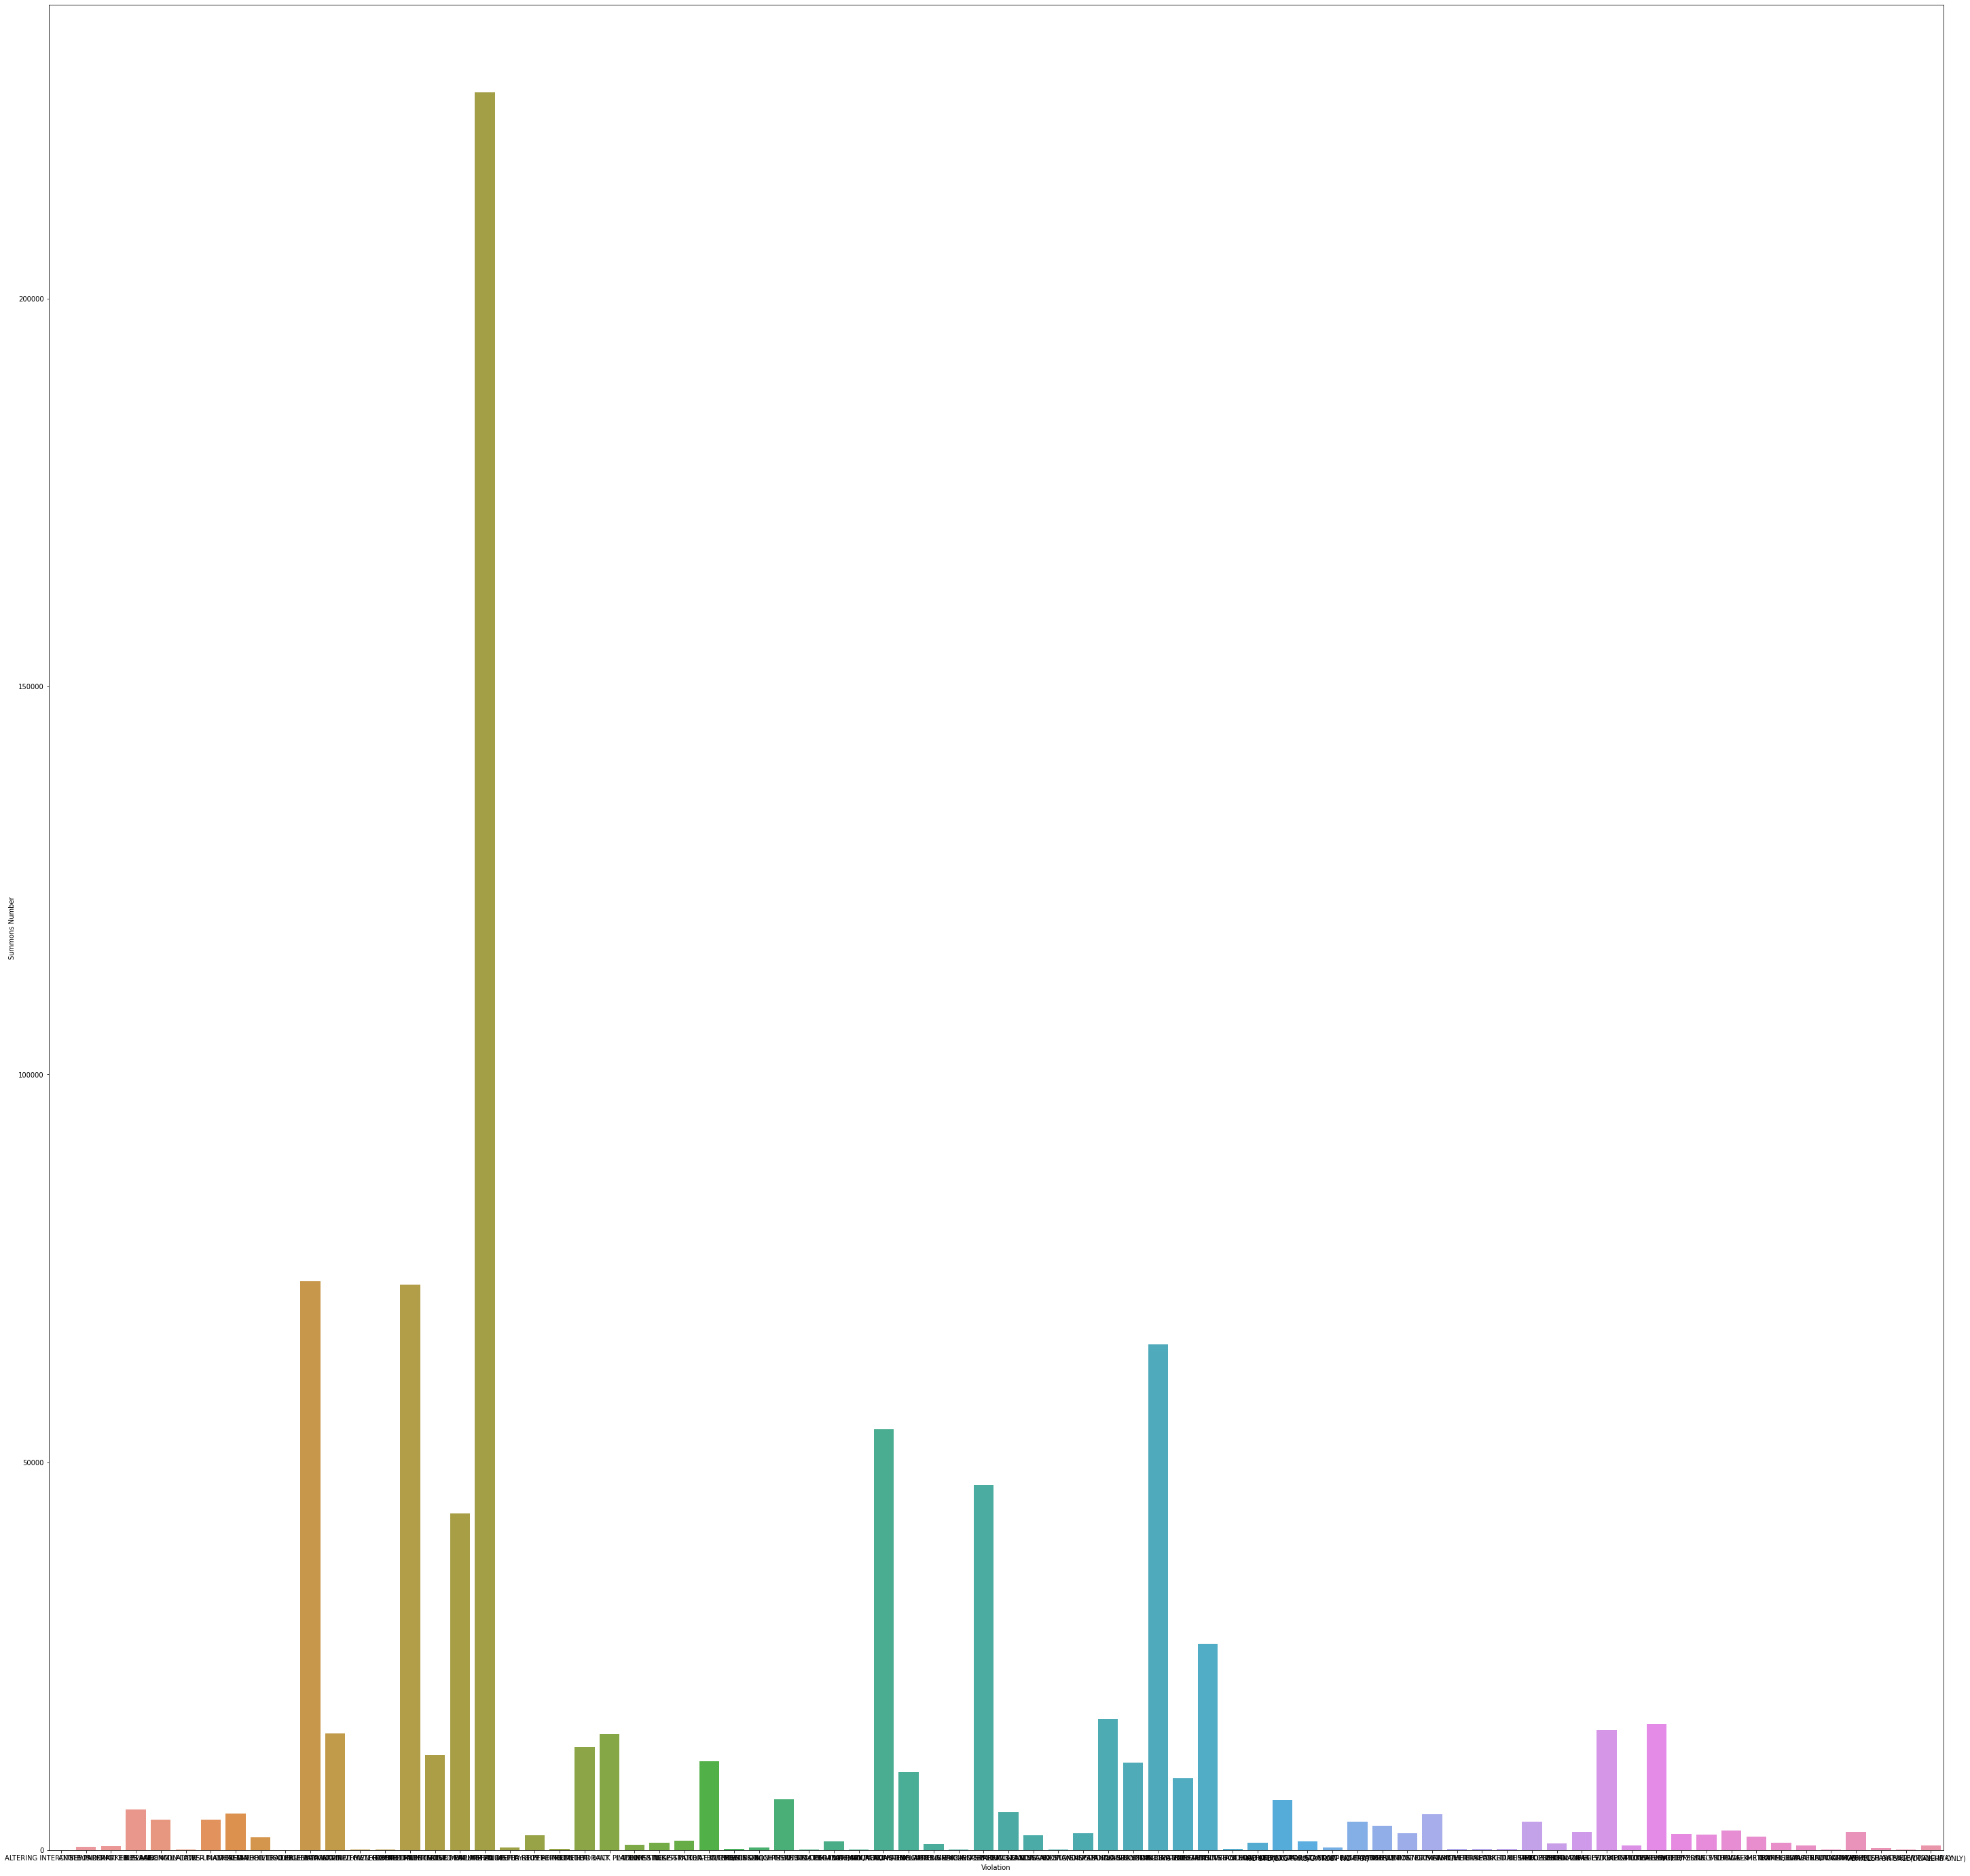

In [68]:
# Graph Granted appeals
granted = df_violation_grouped.loc[df_violation_grouped['Coded Violation Status'] == 'Granted']
plt.figure(figsize=(50, 50))
sns.barplot(x='Violation', y='Summons Number', data=granted) #, order=granted.sort_values('Summons Number').index.values ????

In [114]:
print(fp)

/Users/blake/Box/Project/Data/


In [120]:
granted = granted.drop('index', axis=1)
granted.sort_values(by='Pct', ascending=False)

,Violation,Coded Violation Status,Summons Number,Pct
0,ALTERING INTERCITY BUS PERMIT,Granted,23,100.00
248,VEHICLE FOR SALE(DEALERS ONLY),Granted,80,100.00
194,OVERNIGHT TRACTOR TRAILER PKG,Granted,182,100.00
110,NO OPERATOR NAM/ADD/PH DISPLAY,Granted,54,100.00
105,NIGHTTIME STD/ PKG IN A PARK,Granted,67,100.00
175,NO STOP/STANDNG EXCEPT PAS P/U,Granted,304,92.12
65,FAILURE TO DISPLAY BUS PERMIT,Granted,366,90.59
129,NO PARKING-TAXI STAND,Granted,4845,88.33
193,OTHER,Granted,183,85.92
116,NO PARKING-EXC. AUTH. VEHICLE,Granted,10031,83.19


In [116]:
# Graph granted in altair
g = alt.Chart(granted).mark_bar().encode(
    alt.X('Pct'),
    alt.Y('Violation', sort=alt.EncodingSortField(field="Pct", order="descending")),
).interactive().properties(
    title="Percentage of Appeals Granted By Violation",
    width=800
)

g
# g.save(fp + 'Graphs/granted.html')

alt.Chart(...)

In [90]:
# Graph denied appeals in altair
denied = df_violation_grouped.loc[df_violation_grouped['Coded Violation Status'] == 'Denied']
alt.Chart(denied).mark_bar(color='red').encode(
    alt.X('Pct'),
    alt.Y('Violation', sort=alt.EncodingSortField(field="Pct", order="descending")),
).interactive().properties(
    title="Percentage of Appeals Denied By Violation"
)

alt.Chart(...)

In [93]:
# Graph reduced appeals in altair
reduced = df_violation_grouped.loc[df_violation_grouped['Coded Violation Status'] == 'Reduced']
alt.Chart(reduced).mark_bar(color='purple').encode(
    alt.X('Pct'),
    alt.Y('Violation', sort=alt.EncodingSortField(field="Pct", order="descending")),
).interactive().properties(
    title="Percentage of Appeals Reduced By Violation"
)

alt.Chart(...)

In [95]:
df.corr()

NameError: name 'df' is not defined

In [35]:
# Get Descriptive Status by Coded Violation Status
coded_violation_status_list = list(set(df_violation_grouped['Coded Violation Status'].unique()))
for status in coded_violation_status_list:
    print(status)
    display(df_violation_grouped.loc[df_violation_grouped['Coded Violation Status'] == status].describe())
    print('\n\n')

Denied


,Summons Number,Pct
count,89.000000,89.000000
mean,9226.887640,32.396517
std,19597.331806,16.973632
min,1.000000,3.700000
25%,49.000000,16.670000
50%,575.000000,30.010000
75%,8629.000000,41.470000
max,118511.000000,72.730000





Other


,Summons Number,Pct
count,72.000000,72.000000
mean,292.236111,1.175833
std,621.777654,1.368896
min,1.000000,0.030000
25%,6.250000,0.377500
50%,25.000000,0.715000
75%,223.000000,1.335000
max,3800.000000,6.670000





Reduced


,Summons Number,Pct
count,86.000000,86.000000
mean,8765.034884,24.171395
std,25507.060524,20.295472
min,1.000000,0.280000
25%,18.750000,5.287500
50%,347.000000,19.915000
75%,4696.750000,37.767500
max,182897.000000,76.920000





Granted


,Summons Number,Pct
count,96.000000,96.00000
mean,8787.375000,47.43000
std,26936.902496,26.10976
min,1.000000,2.39000
25%,49.750000,24.33750
50%,797.500000,45.68000
75%,4643.000000,66.25750
max,226576.000000,100.00000


In [ ]:
df_violation_status_dropped.plot.scatter(x='Coded Violation Status', y='Summons Number')